In [14]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
#import numdifftools as nd
import pandas as pd
#import pymc3 as pm

from tqdm import tqdm
from sklearn import preprocessing
from numpy.linalg import multi_dot
import scipy
import scipy.stats as ss
from scipy.stats import invgamma
from scipy.special import gamma
from scipy.special import digamma
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import sklearn.mixture

import logging
import warnings
from functools import partial

In [15]:
def simulate_gandk(theta, num_samples, c = 0.8):
    zu = np.random.randn(num_samples,1)
    f = (theta[0] + theta[1] * (1 + c * (1 - np.exp(-theta[2] * zu)) / (1 + np.exp(-theta[2] * zu))) * (1 + zu**2)**theta[3] * zu)
    return f

def compute_summary_statistics(y):
    quant_y = []
    for i in np.arange(0.125, 1, 0.125):
        quant_y.append(np.quantile(y, i))
    Sa = quant_y[3]
    Sb = quant_y[5] - quant_y[1]
    Sc = (quant_y[5] + quant_y[1] - 2 * quant_y[3]) / Sb
    Sd = (quant_y[6] - quant_y[4] + quant_y[2] - quant_y[0]) / Sb
    return np.array([Sa, Sb, Sc, Sd])

In [16]:
true_theta = np.array([3, 1, 2, 0.5])
num_coeffs = 4
num_latent = 4
num_datasets = 200
num_samples = 200

In [17]:
actual_data = simulate_gandk(true_theta, num_samples)
actual_data

array([[ 2.58524967],
       [ 2.76051665],
       [ 5.08474642],
       [ 2.50369452],
       [ 1.91210744],
       [ 4.28645881],
       [ 3.25432272],
       [ 3.52567859],
       [ 2.6952598 ],
       [ 6.65350407],
       [ 2.28852027],
       [ 3.10840751],
       [ 4.57900523],
       [ 8.50855896],
       [ 4.13298766],
       [ 3.11842851],
       [ 3.30939903],
       [ 5.27227729],
       [ 3.10344674],
       [ 3.38531494],
       [ 2.38704349],
       [ 3.02636788],
       [ 3.30222176],
       [ 3.61792497],
       [ 1.83085069],
       [ 2.85384238],
       [ 1.66389643],
       [ 2.39030639],
       [ 3.00427782],
       [ 2.46617064],
       [ 2.48881896],
       [ 2.70128784],
       [ 2.48114826],
       [ 2.51237657],
       [ 8.02578153],
       [ 5.02549343],
       [ 2.63577277],
       [ 2.45928711],
       [ 3.38810828],
       [ 4.01220144],
       [ 4.3286217 ],
       [ 4.31952953],
       [ 2.44968296],
       [ 2.63133248],
       [ 7.15532061],
       [ 2

In [18]:
actual_summary_statistics = compute_summary_statistics(actual_data)
actual_summary_statistics

array([3.12879592, 1.95655592, 0.40356515, 1.73518254])

In [19]:
def summary_statistics(theta, num_samples, num_datasets):
    n_summary_statistics = np.zeros((num_datasets, num_latent))
    for i in range(0, num_datasets):
        y = simulate_gandk(theta, num_samples)
        n_summary_statistics[i,:] = compute_summary_statistics(y)

    sample_mean = np.mean(n_summary_statistics, axis = 0)
    sample_variance = np.cov(np.array(n_summary_statistics).T)
    return sample_mean, sample_variance

In [20]:
def prior(theta): 
    log_prior = np.sum(np.log(np.exp(theta) / (1 + np.exp(theta))**2))
    return log_prior

def unbiased_log_likelihood(theta):
    ss = summary_statistics(theta, num_samples, num_datasets)
    sample_mean = ss[0]
    sample_variance = ss[1]
    # diff_mean_s = actual_summary_statistics - sample_mean
    # part1 = diff_mean_s.T @ np.linalg.inv(sample_variance) @ diff_mean_s
    # # u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - (self.num_datasets - self.num_coeffs - 2) / (2 * (self.num_datasets-1)) * part1
    # u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - part1

    u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = sample_mean, cov= sample_variance)

    return u_est_log_likelihood

In [21]:
Sigma_0 = np.array([[0.00354862371705708,0.0100432715000140,-0.00892228604398757,-0.0115360428708387],
                   [0.0100432715000140,0.0583090115606533,-0.000835188303313756,-0.0757252081004190],
                   [-0.00892228604398757,-0.000835188303313756,0.0653624479615574,0.0107535785728523],
                   [-0.0115360428708387,-0.0757252081004190,0.0107535785728523,0.167430224841150]])
Sigma_0_inv = scipy.linalg.inv(Sigma_0)
l_0 = scipy.linalg.sqrtm(Sigma_0_inv)
l_0

array([[42.5611843 , -8.28970004,  5.43955494, -1.25900294],
       [-8.28970004,  7.88174052, -1.33079381,  2.31714084],
       [ 5.43955494, -1.33079381,  4.66869461, -0.42495144],
       [-1.25900294,  2.31714084, -0.42495144,  3.30653549]])

In [22]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = 4 # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def log_q(self, theta, mu, l):
        log_q = multivariate_normal.logpdf(theta, mean = mu, cov= np.linalg.inv(l @ l.T))
        return log_q

    def gradient_log_q(self, theta, mu, l): #indep theta
        gradient_log_q_mu = np.matmul(np.matmul(l, l.T), (theta - mu))
        diag_inv_l = np.zeros((num_coeffs, num_coeffs))
        np.fill_diagonal(diag_inv_l, np.diag(np.linalg.inv(l)))
        gradient_log_q_l = (diag_inv_l - np.reshape(theta - mu, (num_coeffs,1)) @ np.reshape(theta - mu, (1,num_coeffs)) @ l).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar 
        gradient_log_q = np.array([gradient_log_q_mu, gradient_log_q_l], dtype=object)
        return gradient_log_q

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = np.array([true_theta[0], np.log(true_theta[1]), true_theta[2], np.log(true_theta[3])])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        # l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        l_0 = np.array([[42.5611843 , -8.28970004,  5.43955494, -1.25900294],
                        [-8.28970004,  7.88174052, -1.33079381,  2.31714084],
                        [ 5.43955494, -1.33079381,  4.66869461, -0.42495144],
                        [-1.25900294,  2.31714084, -0.42495144,  3.30653549]])

        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                # List of gradients
                Gradient_lb_init = []
                lb_0 = []
                theta_0_samples = multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)
                for s in tqdm(range(self.samples)):
                    # True params have been reparam into epsilon
                    theta_tilde_0 = theta_0_samples[s]
                    # alpha_0 = (2 * np.exp(theta_tilde_0[0]) + 1) / (1 + np.exp(theta_tilde_0[0]))
                    # beta_0 = (100 * np.exp(theta_tilde_0[1]) + 0) / (1 + np.exp(theta_tilde_0[1]))
                    # gamma_0 = (0.9 * np.exp(theta_tilde_0[2]) + 0) / (1 + np.exp(theta_tilde_0[2]))

                    alpha_0 = theta_tilde_0[0]
                    # beta_q = (0.05 * np.exp(theta_tilde_q[1]) + 0) / (1 + np.exp(theta_tilde_q[1]))
                    beta_0 = np.exp(theta_tilde_0[1])
                    # gamma_q = (np.exp(theta_tilde_q[2]) - 1) / (1 + np.exp(theta_tilde_q[2]))
                    gamma_0 = theta_tilde_0[2]
                    # delta_q = (0.5 * np.exp(theta_tilde_q[3]) + 0.2) / (1 + np.exp(theta_tilde_q[3]))                    theta_q = np.array([alpha_q, beta_q, gamma_q])
                    delta_0 = np.exp(theta_tilde_0[3])

                    theta_0 = np.array([alpha_0, beta_0, gamma_0, delta_0])
                    
                    # Find gradient of LB
                    h_lambda_init = prior(theta_tilde_0) + unbiased_log_likelihood(theta_0) - self.log_q(theta_tilde_0, mu_0, l_0)
                    gradient_lb_init = self.gradient_log_q(theta_tilde_0, mu_0, l_0) * (h_lambda_init)
                    Gradient_lb_init.append(gradient_lb_init)
                    # Calculate control variates
                    flattened_gradient_log_q = np.concatenate((self.gradient_log_q(theta_tilde_0, mu_0, l_0)[0], self.gradient_log_q(theta_tilde_0, mu_0, l_0)[1]), axis = None)
                    Flattened_gradient_log_q.append(flattened_gradient_log_q)
                    flattened_gradient_lb = np.concatenate((gradient_lb_init[0], gradient_lb_init[1]), axis = None)
                    Flattened_gradient_lb.append(flattened_gradient_lb)
                    # Calculate lower bound
                    lb_0.append(h_lambda_init)
                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)
                for s in range(self.samples):
                    theta_tilde_q = theta_q_samples[s]
                    # Calculate theta from mu, l (lambda)
                    alpha_q = theta_tilde_q[0]
                    # beta_q = (0.05 * np.exp(theta_tilde_q[1]) + 0) / (1 + np.exp(theta_tilde_q[1]))
                    beta_q = np.exp(theta_tilde_q[1])
                    # gamma_q = (np.exp(theta_tilde_q[2]) - 1) / (1 + np.exp(theta_tilde_q[2]))
                    gamma_q = theta_tilde_q[2]
                    # delta_q = (0.5 * np.exp(theta_tilde_q[3]) + 0.2) / (1 + np.exp(theta_tilde_q[3]))                    theta_q = np.array([alpha_q, beta_q, gamma_q])
                    delta_q = np.exp(theta_tilde_q[3])

                    theta_q = np.array([alpha_q, beta_q, gamma_q, delta_q])
                    # Find gradient of LB
                    h_lambda = prior(theta_tilde_q) + unbiased_log_likelihood(theta_q) - self.log_q(theta_tilde_q, mu_q, l_q)
                    # Find gradient of LB
                    gradient_lb = self.gradient_log_q(theta_tilde_q, mu_q, l_q) * (h_lambda - c)

                    Gradient_lb.append(gradient_lb)
                    # Calculate control variates
                    Flattened_gradient_log_q[s] = np.concatenate((self.gradient_log_q(theta_tilde_q, mu_q, l_q)[0], self.gradient_log_q(theta_tilde_q, mu_q, l_q)[1]), axis = None)
                    Flattened_gradient_lb[s] = np.concatenate((gradient_lb[0], gradient_lb[1]), axis = None)
                    # Calc lower bound estimate
                    lb_t.append(h_lambda)
                # Update control variates
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

In [23]:
# Set hyperparameters
stop = 5000
vb = GVB(400, actual_summary_statistics, 0.005, 2500, 100, 0.9, 0.9, 100, 50)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 1/5000 [01:42<142:38:55, 102.73s/it]

LB -10.509154956025272


  0%|          | 2/5000 [02:52<116:03:36, 83.60s/it] 

LB -10.317500656620325


  0%|          | 3/5000 [03:42<94:29:23, 68.07s/it] 

LB -9.844013980246254


  0%|          | 4/5000 [04:47<92:38:56, 66.76s/it]

LB -9.744215449175758


  0%|          | 5/5000 [05:53<92:29:30, 66.66s/it]

LB -9.671143249148242


  0%|          | 6/5000 [06:43<84:40:58, 61.04s/it]

LB -9.710521399542154


  0%|          | 7/5000 [07:31<78:33:13, 56.64s/it]

LB -9.564823287247908


  0%|          | 8/5000 [08:18<74:10:27, 53.49s/it]

LB -9.371521916239027


  0%|          | 9/5000 [09:05<71:19:32, 51.45s/it]

LB -9.401096474535706


  0%|          | 10/5000 [09:52<69:32:51, 50.17s/it]

LB -9.485796589577747


  0%|          | 11/5000 [10:39<68:22:22, 49.34s/it]

LB -9.531297619967127


  0%|          | 12/5000 [11:28<68:08:49, 49.18s/it]

LB -9.61222238396278


  0%|          | 13/5000 [12:17<67:57:04, 49.05s/it]

LB -9.42986519658761


  0%|          | 14/5000 [13:06<67:48:03, 48.95s/it]

LB -9.401060143386907


  0%|          | 15/5000 [15:31<108:08:05, 78.09s/it]

LB -9.287947629590487


  0%|          | 16/5000 [17:22<121:29:07, 87.75s/it]

LB -9.25911163041433


  0%|          | 17/5000 [17:47<95:20:41, 68.88s/it] 

LB -9.37624900670865


  0%|          | 18/5000 [18:11<76:57:26, 55.61s/it]

LB -9.299277724571173


  0%|          | 19/5000 [18:36<64:05:17, 46.32s/it]

LB -9.195876878902467


  0%|          | 20/5000 [19:04<56:27:59, 40.82s/it]

LB -9.012218277455306


  0%|          | 21/5000 [19:32<51:17:54, 37.09s/it]

LB -9.008361022882921


  0%|          | 22/5000 [20:18<54:42:01, 39.56s/it]

LB -8.997240601670565


  0%|          | 23/5000 [21:22<64:58:49, 47.00s/it]

LB -8.867589162522322


  0%|          | 24/5000 [24:12<115:59:14, 83.91s/it]

LB -8.876219793102395


  0%|          | 25/5000 [26:53<148:02:27, 107.13s/it]

LB -8.855325573123071


  1%|          | 26/5000 [29:29<168:15:13, 121.78s/it]

LB -8.853658037399784


  1%|          | 27/5000 [31:52<176:58:50, 128.12s/it]

LB -8.711635253962118


  1%|          | 28/5000 [34:29<188:58:16, 136.83s/it]

LB -8.694374771769258


  1%|          | 29/5000 [37:15<200:58:17, 145.54s/it]

LB -8.567107590325008


  1%|          | 30/5000 [40:12<213:49:51, 154.89s/it]

LB -8.613676362262744


  1%|          | 31/5000 [42:41<211:33:47, 153.28s/it]

LB -8.597596949766485


  1%|          | 32/5000 [45:06<208:00:52, 150.74s/it]

LB -8.518878899557684


  1%|          | 33/5000 [47:32<205:56:12, 149.26s/it]

LB -8.569047569713621


  1%|          | 34/5000 [49:58<204:32:18, 148.28s/it]

LB -8.49567107350831


  1%|          | 35/5000 [52:56<216:36:23, 157.06s/it]

LB -8.49836648486489


  1%|          | 36/5000 [55:45<221:31:18, 160.65s/it]

LB -8.528217653452323


  1%|          | 37/5000 [57:44<204:27:22, 148.31s/it]

LB -8.605482415999383


  1%|          | 38/5000 [58:17<156:53:54, 113.83s/it]

LB -8.495279050695864


  1%|          | 39/5000 [58:52<123:53:57, 89.91s/it] 

LB -8.53277414698459


  1%|          | 40/5000 [59:29<102:03:00, 74.07s/it]

LB -8.540266358022794


  1%|          | 41/5000 [1:00:21<93:04:01, 67.56s/it]

LB -8.53289353539618


  1%|          | 42/5000 [1:00:59<80:42:22, 58.60s/it]

LB -8.39060828503072


  1%|          | 43/5000 [1:01:34<71:14:19, 51.74s/it]

LB -8.495573116261118


  1%|          | 44/5000 [1:02:13<65:45:44, 47.77s/it]

LB -8.508950410882585


  1%|          | 45/5000 [1:02:59<64:52:35, 47.14s/it]

LB -8.361419624325361


  1%|          | 46/5000 [1:04:18<78:15:06, 56.86s/it]

LB -8.441689736312133


  1%|          | 47/5000 [1:05:54<94:06:37, 68.40s/it]

LB -8.34865410999149


  1%|          | 48/5000 [1:06:45<87:03:27, 63.29s/it]

LB -8.389257426540144


  1%|          | 49/5000 [1:08:19<99:33:04, 72.39s/it]

LB -8.370823119995075


  1%|          | 50/5000 [1:09:53<108:31:39, 78.93s/it]

LB -8.277100219386355


  1%|          | 51/5000 [1:13:12<157:58:59, 114.92s/it]

LB -8.301074471256618


  1%|          | 52/5000 [1:16:09<183:40:55, 133.64s/it]

LB -8.308356615099859


  1%|          | 53/5000 [1:19:08<202:22:23, 147.27s/it]

LB -8.394327794757253


  1%|          | 54/5000 [1:21:56<210:48:27, 153.44s/it]

LB -8.422657991033745


  1%|          | 55/5000 [1:24:52<219:57:28, 160.13s/it]

LB -8.264154380845573


  1%|          | 56/5000 [1:27:46<225:42:28, 164.35s/it]

LB -8.354524078394165


  1%|          | 57/5000 [1:30:43<230:45:56, 168.07s/it]

LB -8.33311181131133


  1%|          | 58/5000 [1:33:48<237:45:21, 173.19s/it]

LB -8.260865456499632


  1%|          | 59/5000 [1:37:47<264:52:17, 192.98s/it]

LB -8.386512435290195


  1%|          | 60/5000 [1:42:33<303:22:40, 221.09s/it]

LB -8.432786170847717


  1%|          | 61/5000 [1:50:57<419:40:24, 305.90s/it]

LB -8.491014877015246


  1%|          | 62/5000 [1:53:42<361:23:11, 263.47s/it]

LB -8.241090702986686


  1%|▏         | 63/5000 [1:56:27<320:47:33, 233.92s/it]

LB -8.363281971712336


  1%|▏         | 64/5000 [1:59:12<292:30:11, 213.33s/it]

LB -8.350987837856238


  1%|▏         | 65/5000 [2:01:58<272:56:17, 199.10s/it]

LB -8.29809144873043


  1%|▏         | 66/5000 [2:04:42<258:30:43, 188.62s/it]

LB -8.327570138884704


  1%|▏         | 67/5000 [2:07:30<249:52:31, 182.35s/it]

LB -8.213195459705808


  1%|▏         | 68/5000 [2:10:18<244:10:51, 178.23s/it]

LB -8.238849677571968


  1%|▏         | 69/5000 [2:13:10<241:33:39, 176.36s/it]

LB -8.231188993679547


  1%|▏         | 70/5000 [2:16:03<239:51:02, 175.14s/it]

LB -8.319284452821401


  1%|▏         | 71/5000 [2:18:55<238:49:51, 174.44s/it]

LB -8.239158334540635


  1%|▏         | 72/5000 [2:21:47<237:28:08, 173.48s/it]

LB -8.176262337569343


  1%|▏         | 73/5000 [2:24:39<236:43:20, 172.97s/it]

LB -8.164605355927764


  1%|▏         | 74/5000 [2:27:31<236:19:03, 172.70s/it]

LB -8.264308104116372


  2%|▏         | 75/5000 [2:30:24<236:36:36, 172.95s/it]

LB -8.186516917297832


  2%|▏         | 76/5000 [2:33:19<237:25:46, 173.59s/it]

LB -8.205413408316062


  2%|▏         | 77/5000 [2:36:17<239:08:52, 174.88s/it]

LB -8.1956595621678


  2%|▏         | 78/5000 [2:39:20<242:30:18, 177.37s/it]

LB -8.091490479189842


  2%|▏         | 79/5000 [2:42:14<241:08:52, 176.41s/it]

LB -8.189313683812367


  2%|▏         | 80/5000 [2:45:11<241:18:49, 176.57s/it]

LB -8.201624324426422


  2%|▏         | 81/5000 [2:48:19<245:58:24, 180.02s/it]

LB -8.127475014222854


  2%|▏         | 82/5000 [2:51:20<246:08:58, 180.18s/it]

LB -8.188513996671038


  2%|▏         | 83/5000 [2:54:34<251:45:38, 184.33s/it]

LB -8.192975746966889


  2%|▏         | 84/5000 [2:57:39<251:49:36, 184.41s/it]

LB -8.203284360012853


  2%|▏         | 85/5000 [3:00:39<249:57:52, 183.09s/it]

LB -8.177183540630008


  2%|▏         | 86/5000 [3:03:40<249:10:27, 182.55s/it]

LB -8.187375614252106


  2%|▏         | 87/5000 [3:06:42<248:58:55, 182.44s/it]

LB -8.266473907961235


  2%|▏         | 88/5000 [3:09:46<249:29:14, 182.85s/it]

LB -8.199711707498386


  2%|▏         | 89/5000 [3:12:49<249:23:54, 182.82s/it]

LB -8.177530518180815


  2%|▏         | 90/5000 [3:15:50<248:43:28, 182.36s/it]

LB -8.117733204944052


  2%|▏         | 91/5000 [3:18:47<246:25:21, 180.71s/it]

LB -8.194249064868085


  2%|▏         | 92/5000 [3:21:53<248:28:27, 182.26s/it]

LB -8.145383687663033


  2%|▏         | 93/5000 [3:25:00<250:32:44, 183.81s/it]

LB -8.034373218652455


  2%|▏         | 94/5000 [3:27:55<246:46:57, 181.09s/it]

LB -8.033815027390055


  2%|▏         | 95/5000 [3:30:33<237:10:03, 174.07s/it]

LB -8.172512976220313


  2%|▏         | 96/5000 [3:33:03<227:32:12, 167.03s/it]

LB -8.213659290898272


  2%|▏         | 97/5000 [3:35:39<222:54:15, 163.67s/it]

LB -8.075647817528111


  2%|▏         | 98/5000 [3:38:09<217:19:25, 159.60s/it]

LB -8.140681921034206


  2%|▏         | 99/5000 [3:40:29<209:09:35, 153.64s/it]

LB -8.10134695077385


  2%|▏         | 100/5000 [3:42:51<204:35:59, 150.32s/it]

LB -8.125115112237896


  2%|▏         | 101/5000 [3:45:14<201:29:35, 148.07s/it]

LB Smoothed -8.581634543453118


  2%|▏         | 102/5000 [3:47:40<200:38:05, 147.47s/it]

LB Smoothed -8.55915769694061


  2%|▏         | 103/5000 [3:50:07<200:15:47, 147.22s/it]

LB Smoothed -8.540777658387915


  2%|▏         | 104/5000 [3:52:31<198:51:35, 146.22s/it]

LB Smoothed -8.52399325786711


  2%|▏         | 105/5000 [3:54:58<199:11:38, 146.50s/it]

LB Smoothed -8.508169297901274


  2%|▏         | 106/5000 [3:57:45<207:36:34, 152.72s/it]

LB Smoothed -8.491337574864355


  2%|▏         | 107/5000 [4:00:38<215:43:57, 158.72s/it]

LB Smoothed -8.475421919825857


  2%|▏         | 108/5000 [4:03:25<218:55:51, 161.11s/it]

LB Smoothed -8.461578654136902


  2%|▏         | 109/5000 [4:06:10<220:40:43, 162.43s/it]

LB Smoothed -8.448412438370884


  2%|▏         | 110/5000 [4:08:59<223:14:04, 164.34s/it]

LB Smoothed -8.432970319384145


  2%|▏         | 111/5000 [4:11:47<224:54:13, 165.61s/it]

LB Smoothed -8.417368175618225


  2%|▏         | 112/5000 [4:14:34<225:16:32, 165.92s/it]

LB Smoothed -8.401914846214584


  2%|▏         | 113/5000 [4:17:18<224:20:33, 165.26s/it]

LB Smoothed -8.388496972167644


  2%|▏         | 114/5000 [4:20:04<224:45:32, 165.60s/it]

LB Smoothed -8.374124212946782


  2%|▏         | 115/5000 [4:22:50<224:41:30, 165.59s/it]

LB Smoothed -8.362327231547264


  2%|▏         | 116/5000 [4:24:04<187:38:52, 138.32s/it]

LB Smoothed -8.349986149838571


  2%|▏         | 117/5000 [4:24:43<146:56:48, 108.34s/it]

LB Smoothed -8.33574435222042


  2%|▏         | 118/5000 [4:25:20<118:05:43, 87.08s/it] 

LB Smoothed -8.323107097975974


  2%|▏         | 119/5000 [4:25:58<97:51:32, 72.18s/it] 

LB Smoothed -8.31158685303852


  2%|▏         | 120/5000 [4:26:35<83:36:11, 61.67s/it]

LB Smoothed -8.302383470994972


  2%|▏         | 121/5000 [4:27:12<73:38:53, 54.34s/it]

LB Smoothed -8.291491632641508


  2%|▏         | 122/5000 [4:27:49<66:25:43, 49.02s/it]

LB Smoothed -8.28125630021804


  2%|▏         | 123/5000 [4:28:25<61:13:15, 45.19s/it]

LB Smoothed -8.273589193475965


  2%|▏         | 124/5000 [4:29:01<57:34:43, 42.51s/it]

LB Smoothed -8.264487224432141


  2%|▎         | 125/5000 [4:29:37<54:41:08, 40.38s/it]

LB Smoothed -8.256671875918123


  3%|▎         | 126/5000 [4:30:12<52:35:41, 38.85s/it]

LB Smoothed -8.247338481992506


  3%|▎         | 127/5000 [4:30:47<51:05:00, 37.74s/it]

LB Smoothed -8.240343593660576


  3%|▎         | 128/5000 [4:31:22<49:44:44, 36.76s/it]

LB Smoothed -8.233873475078186


  3%|▎         | 129/5000 [4:31:56<48:51:28, 36.11s/it]

LB Smoothed -8.228195715468289


  3%|▎         | 130/5000 [4:32:30<48:04:07, 35.53s/it]

LB Smoothed -8.221642515985353


  3%|▎         | 131/5000 [4:33:05<47:42:30, 35.27s/it]

LB Smoothed -8.215845893845119


  3%|▎         | 132/5000 [4:33:39<47:20:23, 35.01s/it]

LB Smoothed -8.211223531229297


  3%|▎         | 133/5000 [4:34:15<47:29:29, 35.13s/it]

LB Smoothed -8.205457853261361


  3%|▎         | 134/5000 [4:34:50<47:29:22, 35.13s/it]

LB Smoothed -8.200586328892497


  3%|▎         | 135/5000 [4:35:25<47:30:32, 35.16s/it]

LB Smoothed -8.19556093709853


  3%|▎         | 136/5000 [4:36:00<47:31:45, 35.18s/it]

LB Smoothed -8.189605267335452


  3%|▎         | 137/5000 [4:36:36<47:36:07, 35.24s/it]

LB Smoothed -8.182880849600854


  3%|▎         | 138/5000 [4:37:11<47:42:32, 35.33s/it]

LB Smoothed -8.178098270065606


  3%|▎         | 139/5000 [4:37:47<47:39:17, 35.29s/it]

LB Smoothed -8.172213025104053


  3%|▎         | 140/5000 [4:38:20<46:53:30, 34.73s/it]

LB Smoothed -8.167397617897306


  3%|▎         | 141/5000 [4:38:57<47:53:11, 35.48s/it]

LB Smoothed -8.162553811759347


  3%|▎         | 142/5000 [4:39:35<48:52:24, 36.22s/it]

LB Smoothed -8.157732796281554


  3%|▎         | 143/5000 [4:40:11<48:43:18, 36.11s/it]

LB Smoothed -8.15223823522833


  3%|▎         | 144/5000 [4:40:54<51:20:07, 38.06s/it]

LB Smoothed -8.145988701145656


  3%|▎         | 145/5000 [4:41:30<50:35:54, 37.52s/it]

LB Smoothed -8.141194385126772


  3%|▎         | 146/5000 [4:42:05<49:39:29, 36.83s/it]

LB Smoothed -8.136846424970134


  3%|▎         | 147/5000 [4:42:54<54:38:21, 40.53s/it]

LB Smoothed -8.132878752462403


  3%|▎         | 148/5000 [4:43:46<59:09:29, 43.89s/it]

LB Smoothed -8.128120766251897


  3%|▎         | 149/5000 [4:44:21<55:31:04, 41.20s/it]

LB Smoothed -8.12409154257988


  3%|▎         | 150/5000 [4:45:02<55:28:24, 41.18s/it]

LB Smoothed -8.121400503742484


  3%|▎         | 151/5000 [4:45:58<61:20:42, 45.54s/it]

LB Smoothed -8.117336846410518


  3%|▎         | 152/5000 [4:46:42<60:55:39, 45.24s/it]

LB Smoothed -8.113614747978218


  3%|▎         | 153/5000 [4:47:17<56:43:11, 42.13s/it]

LB Smoothed -8.109432681666163


  3%|▎         | 154/5000 [4:48:13<62:04:16, 46.11s/it]

LB Smoothed -8.105169583148362


  3%|▎         | 155/5000 [4:49:15<68:39:25, 51.01s/it]

LB Smoothed -8.102138373732275


  3%|▎         | 156/5000 [4:49:55<64:01:58, 47.59s/it]

LB Smoothed -8.099028122330395


  3%|▎         | 157/5000 [4:50:37<61:44:18, 45.89s/it]

LB Smoothed -8.095646435144015


  3%|▎         | 158/5000 [4:51:20<60:53:39, 45.27s/it]

LB Smoothed -8.092481406795423


  3%|▎         | 159/5000 [4:52:05<60:44:26, 45.17s/it]

LB Smoothed -8.087424852226865


  3%|▎         | 160/5000 [4:53:01<64:49:04, 48.21s/it]

LB Smoothed -8.082961063921447


  3%|▎         | 161/5000 [4:53:54<66:56:53, 49.81s/it]

LB Smoothed -8.076477078458183


  3%|▎         | 162/5000 [4:54:57<72:04:12, 53.63s/it]

LB Smoothed -8.07274038530278


  3%|▎         | 163/5000 [4:56:19<83:45:19, 62.34s/it]

LB Smoothed -8.068816971454783


  3%|▎         | 164/5000 [4:57:36<89:25:39, 66.57s/it]

LB Smoothed -8.063951324735946


  3%|▎         | 165/5000 [4:58:50<92:35:25, 68.94s/it]

LB Smoothed -8.061051459074381


  3%|▎         | 166/5000 [5:00:07<95:33:21, 71.16s/it]

LB Smoothed -8.056940303289965


  3%|▎         | 167/5000 [5:01:24<98:12:39, 73.16s/it]

LB Smoothed -8.055131521218295


  3%|▎         | 168/5000 [5:02:52<103:49:52, 77.36s/it]

LB Smoothed -8.052438371498466


  3%|▎         | 169/5000 [5:04:13<105:18:24, 78.47s/it]

LB Smoothed -8.05002160653671


  3%|▎         | 170/5000 [5:05:35<106:59:47, 79.75s/it]

LB Smoothed -8.046622623966666


  3%|▎         | 171/5000 [5:06:59<108:39:23, 81.00s/it]

LB Smoothed -8.044245093529383


  3%|▎         | 172/5000 [5:08:23<109:54:23, 81.95s/it]

LB Smoothed -8.041841226123452


  3%|▎         | 173/5000 [5:09:47<110:25:22, 82.35s/it]

LB Smoothed -8.039244865005964


  3%|▎         | 174/5000 [5:11:04<108:21:29, 80.83s/it]

LB Smoothed -8.036854968405255


  4%|▎         | 175/5000 [5:14:41<162:53:22, 121.53s/it]

LB Smoothed -8.03380883040553


  4%|▎         | 176/5000 [5:19:48<237:31:46, 177.26s/it]

LB Smoothed -8.03141087008606


  4%|▎         | 177/5000 [5:25:12<296:35:50, 221.39s/it]

LB Smoothed -8.027536402874404


  4%|▎         | 178/5000 [5:30:45<341:19:38, 254.83s/it]

LB Smoothed -8.025473025141476


  4%|▎         | 179/5000 [5:36:17<372:19:39, 278.03s/it]

LB Smoothed -8.02267039342168


  4%|▎         | 180/5000 [5:41:48<393:24:47, 293.84s/it]

LB Smoothed -8.019578892228884


  4%|▎         | 181/5000 [5:47:04<402:10:23, 300.44s/it]

LB Smoothed -8.017114346113978


  4%|▎         | 182/5000 [5:51:39<392:05:34, 292.97s/it]

LB Smoothed -8.013704907228325


  4%|▎         | 183/5000 [5:55:19<362:24:24, 270.85s/it]

LB Smoothed -8.010460441126618


  4%|▎         | 184/5000 [5:58:58<341:39:08, 255.39s/it]

LB Smoothed -8.006911002813625


  4%|▎         | 185/5000 [6:02:32<324:53:17, 242.91s/it]

LB Smoothed -8.003618856936972


  4%|▎         | 186/5000 [6:06:11<315:25:54, 235.89s/it]

LB Smoothed -8.000022068583455


  4%|▎         | 187/5000 [6:09:54<310:09:20, 231.99s/it]

LB Smoothed -7.996730453581523


  4%|▍         | 188/5000 [6:13:32<304:33:22, 227.85s/it]

LB Smoothed -7.9937109107565085


  4%|▍         | 189/5000 [6:17:21<304:56:42, 228.19s/it]

LB Smoothed -7.9916390560464885


  4%|▍         | 190/5000 [27:51:44<31343:13:25, 23458.55s/it]

LB Smoothed -7.989703819463635


  4%|▍         | 191/5000 [27:55:32<22027:02:26, 16489.36s/it]

LB Smoothed -7.986362745310435


  4%|▍         | 192/5000 [27:58:53<15496:21:17, 11602.93s/it]

LB Smoothed -7.984615246583907


  4%|▍         | 193/5000 [28:02:28<10931:24:00, 8186.61s/it] 

LB Smoothed -7.983575862704323


  4%|▍         | 194/5000 [28:06:22<7743:50:26, 5800.63s/it] 

LB Smoothed -7.982160746520773


  4%|▍         | 195/5000 [28:10:10<5511:06:59, 4129.04s/it]

LB Smoothed -7.978540047668686


  4%|▍         | 196/5000 [28:13:25<3934:52:57, 2948.70s/it]

LB Smoothed -7.9746601831150326


  4%|▍         | 197/5000 [28:17:16<2846:14:17, 2133.35s/it]

LB Smoothed -7.973801682173949


  4%|▍         | 198/5000 [28:21:17<2088:31:42, 1565.74s/it]

LB Smoothed -7.970557866973172


  4%|▍         | 199/5000 [28:26:13<1580:07:58, 1184.85s/it]

LB Smoothed -7.968259616284309


  4%|▍         | 200/5000 [28:32:03<1245:40:25, 934.26s/it] 

LB Smoothed -7.9651729005755385


  4%|▍         | 201/5000 [28:36:50<986:50:04, 740.28s/it] 

LB Smoothed -7.963098012523786


  4%|▍         | 202/5000 [28:40:24<776:03:23, 582.29s/it]

LB Smoothed -7.960924970079133


  4%|▍         | 203/5000 [28:44:43<646:28:34, 485.16s/it]

LB Smoothed -7.958826706209374


  4%|▍         | 204/5000 [28:49:26<565:44:48, 424.66s/it]

LB Smoothed -7.9567110296070505


  4%|▍         | 205/5000 [28:53:39<497:06:25, 373.22s/it]

LB Smoothed -7.9549620077353005


  4%|▍         | 206/5000 [28:58:34<465:48:14, 349.79s/it]

LB Smoothed -7.952822357782149


  4%|▍         | 207/5000 [29:02:49<427:36:51, 321.18s/it]

LB Smoothed -7.951748395473634


  4%|▍         | 208/5000 [29:06:41<391:57:23, 294.46s/it]

LB Smoothed -7.950037273762718


  4%|▍         | 209/5000 [29:10:23<362:55:31, 272.71s/it]

LB Smoothed -7.949265039805775


  4%|▍         | 210/5000 [29:14:07<343:39:30, 258.28s/it]

LB Smoothed -7.947309676476631


  4%|▍         | 211/5000 [29:17:47<328:11:29, 246.71s/it]

LB Smoothed -7.945082187394806


  4%|▍         | 212/5000 [29:21:23<315:40:37, 237.35s/it]

LB Smoothed -7.943460056088532


  4%|▍         | 213/5000 [29:25:27<318:19:18, 239.39s/it]

LB Smoothed -7.94200985201738


  4%|▍         | 214/5000 [29:29:02<308:35:17, 232.12s/it]

LB Smoothed -7.938512875760577


  4%|▍         | 215/5000 [29:32:24<296:39:14, 223.19s/it]

LB Smoothed -7.934794977677033


  4%|▍         | 216/5000 [29:35:47<288:19:31, 216.97s/it]

LB Smoothed -7.933177609330389


  4%|▍         | 217/5000 [29:39:18<285:57:23, 215.23s/it]

LB Smoothed -7.929646586394333


  4%|▍         | 218/5000 [29:42:38<279:51:49, 210.69s/it]

LB Smoothed -7.927373941119986


  4%|▍         | 219/5000 [29:45:55<274:11:11, 206.46s/it]

LB Smoothed -7.92438833936292


  4%|▍         | 220/5000 [29:49:52<286:20:29, 215.65s/it]

LB Smoothed -7.922003672916252


  4%|▍         | 221/5000 [29:53:39<291:05:44, 219.28s/it]

LB Smoothed -7.919711569357527


  4%|▍         | 222/5000 [29:58:11<311:47:09, 234.92s/it]

LB Smoothed -7.917421577028688


  4%|▍         | 223/5000 [30:03:22<341:55:37, 257.68s/it]

LB Smoothed -7.91576285464969


  4%|▍         | 224/5000 [30:07:02<327:00:31, 246.49s/it]

LB Smoothed -7.913592621566208


  4%|▍         | 225/5000 [30:10:36<314:04:23, 236.79s/it]

LB Smoothed -7.912879457499739


  5%|▍         | 226/5000 [30:14:00<300:59:39, 226.98s/it]

LB Smoothed -7.909871836509395


  5%|▍         | 227/5000 [30:17:34<295:28:11, 222.86s/it]

LB Smoothed -7.908371481031888


  5%|▍         | 228/5000 [30:21:21<297:21:34, 224.33s/it]

LB Smoothed -7.9068696404933725


  5%|▍         | 229/5000 [30:25:00<295:07:51, 222.69s/it]

LB Smoothed -7.905314774739113


  5%|▍         | 230/5000 [30:28:43<295:03:22, 222.68s/it]

LB Smoothed -7.90276705570352


  5%|▍         | 231/5000 [30:32:30<296:36:59, 223.91s/it]

LB Smoothed -7.900124387796678


  5%|▍         | 232/5000 [30:36:24<300:48:20, 227.12s/it]

LB Smoothed -7.897692124814955


  5%|▍         | 233/5000 [30:40:09<299:54:13, 226.48s/it]

LB Smoothed -7.895933724391624


  5%|▍         | 234/5000 [30:44:17<308:14:15, 232.83s/it]

LB Smoothed -7.893837226496911


  5%|▍         | 235/5000 [30:47:53<301:35:49, 227.86s/it]

LB Smoothed -7.89246692176621


  5%|▍         | 236/5000 [30:51:38<300:14:32, 226.88s/it]

LB Smoothed -7.8907014949438645


  5%|▍         | 237/5000 [30:55:21<298:43:58, 225.79s/it]

LB Smoothed -7.889407637880639


  5%|▍         | 238/5000 [30:59:01<296:11:54, 223.92s/it]

LB Smoothed -7.88883295074867


  5%|▍         | 239/5000 [31:02:39<293:47:52, 222.15s/it]

LB Smoothed -7.886619602228765


  5%|▍         | 240/5000 [31:06:09<289:17:26, 218.79s/it]

LB Smoothed -7.884292800440844


  5%|▍         | 241/5000 [31:09:50<290:04:10, 219.43s/it]

LB Smoothed -7.883664912476406


  5%|▍         | 242/5000 [31:10:45<224:35:24, 169.93s/it]

LB Smoothed -7.882632114041813


  5%|▍         | 243/5000 [31:11:34<176:51:43, 133.85s/it]

LB Smoothed -7.881525192027228


  5%|▍         | 244/5000 [31:12:25<143:59:30, 108.99s/it]

LB Smoothed -7.88121772145129


  5%|▍         | 245/5000 [31:13:14<120:02:54, 90.89s/it] 

LB Smoothed -7.880045674296785


  5%|▍         | 246/5000 [31:14:09<105:53:43, 80.19s/it]

LB Smoothed -7.879019402861999


  5%|▍         | 247/5000 [31:14:58<93:23:43, 70.74s/it] 

LB Smoothed -7.878244999661186


  5%|▍         | 248/5000 [31:15:46<84:30:05, 64.02s/it]

LB Smoothed -7.877308103525911


  5%|▍         | 249/5000 [31:16:39<79:56:58, 60.58s/it]

LB Smoothed -7.876147030025347


  5%|▌         | 250/5000 [31:17:31<76:31:06, 57.99s/it]

LB Smoothed -7.8766832975447585


  5%|▌         | 251/5000 [31:18:26<75:25:55, 57.18s/it]

LB Smoothed -7.875719520240849


  5%|▌         | 252/5000 [31:19:26<76:37:25, 58.10s/it]

LB Smoothed -7.873974029604263


  5%|▌         | 253/5000 [31:20:29<78:30:40, 59.54s/it]

LB Smoothed -7.87310223654496


  5%|▌         | 254/5000 [31:21:25<77:02:49, 58.44s/it]

LB Smoothed -7.871292391704137


  5%|▌         | 255/5000 [31:22:16<73:51:05, 56.03s/it]

LB Smoothed -7.869829283538129


  5%|▌         | 256/5000 [31:23:07<71:57:42, 54.61s/it]

LB Smoothed -7.867499418456557


  5%|▌         | 257/5000 [31:23:58<70:24:57, 53.45s/it]

LB Smoothed -7.866609397675778


  5%|▌         | 258/5000 [31:24:48<69:00:28, 52.39s/it]

LB Smoothed -7.867061048899615


  5%|▌         | 259/5000 [31:25:36<67:37:27, 51.35s/it]

LB Smoothed -7.865314410526875


  5%|▌         | 260/5000 [31:26:49<75:57:35, 57.69s/it]

LB Smoothed -7.86509701374575


  5%|▌         | 261/5000 [31:27:46<75:30:54, 57.37s/it]

LB Smoothed -7.864802422379316


  5%|▌         | 262/5000 [31:28:44<75:51:18, 57.64s/it]

LB Smoothed -7.862634015131075


  5%|▌         | 263/5000 [31:29:30<71:09:20, 54.08s/it]

LB Smoothed -7.862924261905527


  5%|▌         | 264/5000 [31:30:16<68:15:32, 51.89s/it]

LB Smoothed -7.86138120871938


  5%|▌         | 265/5000 [31:31:09<68:19:51, 51.95s/it]

LB Smoothed -7.861306359015464


  5%|▌         | 266/5000 [31:32:01<68:21:41, 51.99s/it]

LB Smoothed -7.8592177295744055


  5%|▌         | 267/5000 [31:32:47<66:17:05, 50.42s/it]

LB Smoothed -7.858554323588116


  5%|▌         | 268/5000 [31:33:35<65:02:46, 49.49s/it]

LB Smoothed -7.856768259441024


  5%|▌         | 269/5000 [31:34:26<65:44:54, 50.03s/it]

LB Smoothed -7.8548775708451215


  5%|▌         | 270/5000 [31:35:15<65:11:33, 49.62s/it]

LB Smoothed -7.852678039067184


  5%|▌         | 271/5000 [31:36:02<64:29:50, 49.10s/it]

LB Smoothed -7.851828270759316


  5%|▌         | 272/5000 [31:37:04<69:27:05, 52.88s/it]

LB Smoothed -7.8506819284999025


  5%|▌         | 273/5000 [31:37:55<68:34:35, 52.23s/it]

LB Smoothed -7.84853002541034


  5%|▌         | 274/5000 [31:38:46<68:06:36, 51.88s/it]

LB Smoothed -7.847592313591647


  6%|▌         | 275/5000 [31:39:35<66:50:30, 50.93s/it]

LB Smoothed -7.8452397907411475


  6%|▌         | 276/5000 [31:40:24<66:03:34, 50.34s/it]

LB Smoothed -7.845724835941879


  6%|▌         | 277/5000 [31:41:15<66:15:19, 50.50s/it]

LB Smoothed -7.8452301533720386


  6%|▌         | 278/5000 [31:42:02<64:51:37, 49.45s/it]

LB Smoothed -7.844211993172487


  6%|▌         | 279/5000 [31:42:50<64:36:57, 49.27s/it]

LB Smoothed -7.8434186956078875


  6%|▌         | 280/5000 [31:43:37<63:28:26, 48.41s/it]

LB Smoothed -7.842790540160846


  6%|▌         | 281/5000 [31:44:27<64:12:53, 48.99s/it]

LB Smoothed -7.841904959993842


  6%|▌         | 282/5000 [31:45:14<63:25:22, 48.39s/it]

LB Smoothed -7.8411955330575545


  6%|▌         | 283/5000 [31:46:02<63:22:28, 48.37s/it]

LB Smoothed -7.841026834153633


  6%|▌         | 284/5000 [31:46:52<63:57:30, 48.82s/it]

LB Smoothed -7.840225338072815


  6%|▌         | 285/5000 [31:47:38<62:52:34, 48.01s/it]

LB Smoothed -7.839102773935132


  6%|▌         | 286/5000 [31:48:30<64:26:16, 49.21s/it]

LB Smoothed -7.837619038648585


  6%|▌         | 287/5000 [31:49:18<63:43:05, 48.67s/it]

LB Smoothed -7.837509581912161


  6%|▌         | 288/5000 [31:50:07<63:59:51, 48.89s/it]

LB Smoothed -7.835043337319356


  6%|▌         | 289/5000 [31:50:55<63:30:39, 48.53s/it]

LB Smoothed -7.832605214553834


  6%|▌         | 290/5000 [31:51:43<63:19:17, 48.40s/it]

LB Smoothed -7.831359339395755


  6%|▌         | 291/5000 [31:52:29<62:28:59, 47.77s/it]

LB Smoothed -7.829306581941534


  6%|▌         | 292/5000 [31:53:18<62:45:05, 47.98s/it]

LB Smoothed -7.827421916968962


  6%|▌         | 293/5000 [31:54:05<62:21:06, 47.69s/it]

LB Smoothed -7.825134598152736


  6%|▌         | 294/5000 [31:54:54<62:54:00, 48.12s/it]

LB Smoothed -7.824206674861647


  6%|▌         | 295/5000 [31:55:40<62:14:59, 47.63s/it]

LB Smoothed -7.82311197401325


  6%|▌         | 296/5000 [31:56:28<62:16:38, 47.66s/it]

LB Smoothed -7.820222648160475


  6%|▌         | 297/5000 [31:57:16<62:08:34, 47.57s/it]

LB Smoothed -7.818659375041672


  6%|▌         | 298/5000 [31:58:02<61:35:47, 47.16s/it]

LB Smoothed -7.816891241358286


  6%|▌         | 299/5000 [31:58:50<61:54:50, 47.41s/it]

LB Smoothed -7.8162565973704305


  6%|▌         | 300/5000 [31:59:41<63:17:35, 48.48s/it]

LB Smoothed -7.81524928821783


  6%|▌         | 301/5000 [32:00:27<62:18:04, 47.73s/it]

LB Smoothed -7.815333411923833


  6%|▌         | 302/5000 [32:01:14<62:01:20, 47.53s/it]

LB Smoothed -7.814804310159549


  6%|▌         | 303/5000 [32:02:02<62:14:02, 47.70s/it]

LB Smoothed -7.8124408836644355


  6%|▌         | 304/5000 [32:02:47<61:25:26, 47.09s/it]

LB Smoothed -7.811800307628143


  6%|▌         | 305/5000 [32:03:35<61:42:06, 47.31s/it]

LB Smoothed -7.812181115357926


  6%|▌         | 306/5000 [32:04:26<63:08:33, 48.43s/it]

LB Smoothed -7.81038906838137


  6%|▌         | 307/5000 [32:05:13<62:30:14, 47.95s/it]

LB Smoothed -7.808686419894556


  6%|▌         | 308/5000 [32:06:01<62:33:10, 47.99s/it]

LB Smoothed -7.807107171398855


  6%|▌         | 309/5000 [32:06:50<62:39:38, 48.09s/it]

LB Smoothed -7.806429576396829


  6%|▌         | 310/5000 [32:07:36<62:05:33, 47.66s/it]

LB Smoothed -7.804592247917326


  6%|▌         | 311/5000 [32:08:24<62:09:03, 47.72s/it]

LB Smoothed -7.802197674037893


  6%|▌         | 312/5000 [32:09:12<62:16:29, 47.82s/it]

LB Smoothed -7.800576617896476


  6%|▋         | 313/5000 [32:10:02<62:52:46, 48.30s/it]

LB Smoothed -7.799420633963898


  6%|▋         | 314/5000 [32:10:50<63:03:54, 48.45s/it]

LB Smoothed -7.800795744366497


  6%|▋         | 315/5000 [32:11:38<62:53:12, 48.32s/it]

LB Smoothed -7.798963420487252


  6%|▋         | 316/5000 [32:12:27<62:51:41, 48.31s/it]

LB Smoothed -7.799713840764667


  6%|▋         | 317/5000 [32:13:13<62:08:09, 47.77s/it]

LB Smoothed -7.798995056948926


  6%|▋         | 318/5000 [32:14:03<63:00:46, 48.45s/it]

LB Smoothed -7.797948449928797


  6%|▋         | 319/5000 [32:14:53<63:33:22, 48.88s/it]

LB Smoothed -7.798049804028943


  6%|▋         | 320/5000 [32:15:41<63:03:32, 48.51s/it]

LB Smoothed -7.797423968113166


  6%|▋         | 321/5000 [32:16:30<63:22:22, 48.76s/it]

LB Smoothed -7.795251297243892


  6%|▋         | 322/5000 [32:17:18<62:55:32, 48.43s/it]

LB Smoothed -7.793270038541124


  6%|▋         | 323/5000 [32:17:57<59:11:39, 45.56s/it]

LB Smoothed -7.790964034409975


  6%|▋         | 324/5000 [32:18:26<53:01:42, 40.83s/it]

LB Smoothed -7.789331367344441


  6%|▋         | 325/5000 [32:19:00<50:21:08, 38.77s/it]

LB Smoothed -7.789237764923378


  7%|▋         | 326/5000 [32:19:36<49:10:35, 37.88s/it]

LB Smoothed -7.7873643998759965


  7%|▋         | 327/5000 [32:20:06<46:08:56, 35.55s/it]

LB Smoothed -7.78544492372634


  7%|▋         | 328/5000 [32:20:36<43:50:54, 33.79s/it]

LB Smoothed -7.783714183735379


  7%|▋         | 329/5000 [32:21:06<42:15:38, 32.57s/it]

LB Smoothed -7.783593932670085


  7%|▋         | 330/5000 [32:21:36<41:25:03, 31.93s/it]

LB Smoothed -7.78265865436946


  7%|▋         | 331/5000 [32:22:06<40:36:47, 31.31s/it]

LB Smoothed -7.782411152093855


  7%|▋         | 332/5000 [32:22:36<39:55:19, 30.79s/it]

LB Smoothed -7.780737512333381


  7%|▋         | 333/5000 [32:23:06<39:55:25, 30.80s/it]

LB Smoothed -7.779922866140466


  7%|▋         | 334/5000 [32:23:37<39:57:54, 30.83s/it]

LB Smoothed -7.778288925159223


  7%|▋         | 335/5000 [32:24:09<40:08:14, 30.97s/it]

LB Smoothed -7.77853781426037


  7%|▋         | 336/5000 [32:24:40<40:13:51, 31.05s/it]

LB Smoothed -7.776517874232444


  7%|▋         | 337/5000 [32:25:11<40:09:13, 31.00s/it]

LB Smoothed -7.774077813430503


  7%|▋         | 338/5000 [32:25:44<40:59:26, 31.65s/it]

LB Smoothed -7.772121168553643


  7%|▋         | 339/5000 [32:26:15<40:48:58, 31.53s/it]

LB Smoothed -7.770512503661409


  7%|▋         | 340/5000 [32:26:46<40:38:32, 31.40s/it]

LB Smoothed -7.768651189590511


  7%|▋         | 341/5000 [32:27:20<41:27:31, 32.04s/it]

LB Smoothed -7.766548419330641


  7%|▋         | 342/5000 [32:27:54<42:15:49, 32.66s/it]

LB Smoothed -7.76486252846327


  7%|▋         | 343/5000 [32:28:25<41:33:26, 32.13s/it]

LB Smoothed -7.763518287390486


  7%|▋         | 344/5000 [32:28:54<40:34:21, 31.37s/it]

LB Smoothed -7.760477935412381


  7%|▋         | 345/5000 [32:29:24<39:52:04, 30.83s/it]

LB Smoothed -7.7584725142248105


  7%|▋         | 346/5000 [32:29:53<39:17:39, 30.40s/it]

LB Smoothed -7.75599829488028


  7%|▋         | 347/5000 [32:30:23<38:57:30, 30.14s/it]

LB Smoothed -7.753234967901044


  7%|▋         | 348/5000 [32:30:53<38:45:41, 30.00s/it]

LB Smoothed -7.751239917655578


  7%|▋         | 349/5000 [32:31:22<38:28:04, 29.78s/it]

LB Smoothed -7.748662954395179


  7%|▋         | 350/5000 [32:31:51<38:18:31, 29.66s/it]

LB Smoothed -7.7467569382769685


  7%|▋         | 351/5000 [32:32:21<38:12:41, 29.59s/it]

LB Smoothed -7.745389803033214


  7%|▋         | 352/5000 [32:32:50<38:11:46, 29.58s/it]

LB Smoothed -7.743003427451717


  7%|▋         | 353/5000 [32:33:20<38:18:30, 29.68s/it]

LB Smoothed -7.741815208510667


  7%|▋         | 354/5000 [32:33:50<38:17:49, 29.67s/it]

LB Smoothed -7.74055197569547


  7%|▋         | 355/5000 [32:34:29<42:05:39, 32.62s/it]

LB Smoothed -7.739303683804604


  7%|▋         | 356/5000 [32:35:14<46:49:36, 36.30s/it]

LB Smoothed -7.736992441964973


  7%|▋         | 357/5000 [32:36:00<50:22:36, 39.06s/it]

LB Smoothed -7.73456588736526


  7%|▋         | 358/5000 [32:36:46<53:02:57, 41.14s/it]

LB Smoothed -7.732137529666026


  7%|▋         | 359/5000 [32:37:33<55:33:20, 43.09s/it]

LB Smoothed -7.730939565687292


  7%|▋         | 360/5000 [32:38:21<57:21:17, 44.50s/it]

LB Smoothed -7.729441801423984


  7%|▋         | 361/5000 [32:39:09<58:35:18, 45.47s/it]

LB Smoothed -7.728712413368913


  7%|▋         | 362/5000 [32:39:56<59:07:58, 45.90s/it]

LB Smoothed -7.725590743175528


  7%|▋         | 363/5000 [32:40:43<59:49:55, 46.45s/it]

LB Smoothed -7.7234166575087695


  7%|▋         | 364/5000 [32:41:30<59:57:48, 46.56s/it]

LB Smoothed -7.72094923177063


  7%|▋         | 365/5000 [32:42:17<60:08:10, 46.71s/it]

LB Smoothed -7.719829987476269


  7%|▋         | 366/5000 [32:43:04<60:04:18, 46.67s/it]

LB Smoothed -7.7178837000661815


  7%|▋         | 367/5000 [32:43:51<60:22:54, 46.92s/it]

LB Smoothed -7.7150414074598


  7%|▋         | 368/5000 [32:44:42<61:47:59, 48.03s/it]

LB Smoothed -7.713637156931295


  7%|▋         | 369/5000 [32:45:28<60:59:55, 47.42s/it]

LB Smoothed -7.713434690315363


  7%|▋         | 370/5000 [32:46:14<60:27:56, 47.01s/it]

LB Smoothed -7.711592455715575


  7%|▋         | 371/5000 [32:46:59<59:46:10, 46.48s/it]

LB Smoothed -7.709806836935512


  7%|▋         | 372/5000 [32:47:47<60:22:06, 46.96s/it]

LB Smoothed -7.708366833910711


  7%|▋         | 373/5000 [32:48:36<60:52:19, 47.36s/it]

LB Smoothed -7.706409108962829


  7%|▋         | 374/5000 [32:49:22<60:23:00, 46.99s/it]

LB Smoothed -7.704831098836332


  8%|▊         | 375/5000 [32:50:08<60:13:22, 46.88s/it]

LB Smoothed -7.701895529877717


  8%|▊         | 376/5000 [32:50:55<60:14:11, 46.90s/it]

LB Smoothed -7.699824850150897


  8%|▊         | 377/5000 [32:51:43<60:41:46, 47.26s/it]

LB Smoothed -7.697721080112593


  8%|▊         | 378/5000 [32:52:30<60:32:42, 47.16s/it]

LB Smoothed -7.695741600722722


  8%|▊         | 379/5000 [32:53:17<60:22:16, 47.03s/it]

LB Smoothed -7.692726227768616


  8%|▊         | 380/5000 [32:54:03<59:50:43, 46.63s/it]

LB Smoothed -7.6910010400554105


  8%|▊         | 381/5000 [32:54:49<59:37:21, 46.47s/it]

LB Smoothed -7.689144303647378


  8%|▊         | 382/5000 [32:55:30<57:37:50, 44.93s/it]

LB Smoothed -7.686113988181131


  8%|▊         | 383/5000 [32:56:07<54:31:19, 42.51s/it]

LB Smoothed -7.68545337426866


  8%|▊         | 384/5000 [32:56:46<53:10:28, 41.47s/it]

LB Smoothed -7.683307353573526


  8%|▊         | 385/5000 [32:57:19<49:57:21, 38.97s/it]

LB Smoothed -7.6815382055734185


  8%|▊         | 386/5000 [32:57:54<48:28:36, 37.82s/it]

LB Smoothed -7.678723662004444


  8%|▊         | 387/5000 [32:58:27<46:20:54, 36.17s/it]

LB Smoothed -7.6778535288073275


  8%|▊         | 388/5000 [32:58:58<44:37:45, 34.84s/it]

LB Smoothed -7.676113165873543


  8%|▊         | 389/5000 [32:59:30<43:23:57, 33.88s/it]

LB Smoothed -7.675055524764111


  8%|▊         | 390/5000 [33:00:02<42:30:45, 33.20s/it]

LB Smoothed -7.672976572952702


  8%|▊         | 391/5000 [33:00:34<41:57:34, 32.77s/it]

LB Smoothed -7.671020229976008


  8%|▊         | 392/5000 [33:01:05<41:23:31, 32.34s/it]

LB Smoothed -7.670536550097073


  8%|▊         | 393/5000 [33:01:37<41:09:50, 32.17s/it]

LB Smoothed -7.670177259196335


  8%|▊         | 394/5000 [33:02:08<40:52:04, 31.94s/it]

LB Smoothed -7.669075070346166


  8%|▊         | 395/5000 [33:02:40<40:45:45, 31.87s/it]

LB Smoothed -7.668987430357972


  8%|▊         | 396/5000 [33:03:11<40:38:08, 31.77s/it]

LB Smoothed -7.668516769062547


  8%|▊         | 397/5000 [33:03:42<40:22:26, 31.58s/it]

LB Smoothed -7.667405581014377


  8%|▊         | 398/5000 [33:04:14<40:22:05, 31.58s/it]

LB Smoothed -7.665563039944119


  8%|▊         | 399/5000 [33:04:46<40:21:57, 31.58s/it]

LB Smoothed -7.663272491364485


  8%|▊         | 400/5000 [33:05:17<40:07:52, 31.41s/it]

LB Smoothed -7.661766676374253


  8%|▊         | 401/5000 [33:05:48<40:10:46, 31.45s/it]

LB Smoothed -7.660444654393124


  8%|▊         | 402/5000 [33:06:19<39:59:26, 31.31s/it]

LB Smoothed -7.6606217474255915


  8%|▊         | 403/5000 [33:06:51<40:08:16, 31.43s/it]

LB Smoothed -7.659066371772815


  8%|▊         | 404/5000 [33:07:22<40:13:43, 31.51s/it]

LB Smoothed -7.657439319414773


  8%|▊         | 405/5000 [33:07:55<40:27:14, 31.69s/it]

LB Smoothed -7.656882071604444


  8%|▊         | 406/5000 [33:08:26<40:23:39, 31.65s/it]

LB Smoothed -7.656330604114298


  8%|▊         | 407/5000 [33:08:58<40:19:01, 31.60s/it]

LB Smoothed -7.654851236871957


  8%|▊         | 408/5000 [33:09:29<40:22:26, 31.65s/it]

LB Smoothed -7.653416282740793


  8%|▊         | 409/5000 [33:10:01<40:29:16, 31.75s/it]

LB Smoothed -7.652731320553698


  8%|▊         | 410/5000 [33:10:33<40:25:24, 31.70s/it]

LB Smoothed -7.651535239105162


  8%|▊         | 411/5000 [33:11:05<40:30:59, 31.78s/it]

LB Smoothed -7.650710245572165


  8%|▊         | 412/5000 [33:11:37<40:40:10, 31.91s/it]

LB Smoothed -7.650306159640493


  8%|▊         | 413/5000 [33:12:09<40:34:10, 31.84s/it]

LB Smoothed -7.648070266517531


  8%|▊         | 414/5000 [33:12:41<40:33:26, 31.84s/it]

LB Smoothed -7.648249495996619


  8%|▊         | 415/5000 [33:13:12<40:16:58, 31.63s/it]

LB Smoothed -7.646405307071795


  8%|▊         | 416/5000 [33:13:43<40:11:43, 31.57s/it]

LB Smoothed -7.644913523934182


  8%|▊         | 417/5000 [33:14:14<39:55:14, 31.36s/it]

LB Smoothed -7.643020114788019


  8%|▊         | 418/5000 [33:14:45<39:44:15, 31.22s/it]

LB Smoothed -7.642397761314228


  8%|▊         | 419/5000 [33:15:16<39:44:43, 31.23s/it]

LB Smoothed -7.641170966515648


  8%|▊         | 420/5000 [33:15:47<39:41:38, 31.20s/it]

LB Smoothed -7.6406855577185455


  8%|▊         | 421/5000 [33:16:19<39:46:54, 31.28s/it]

LB Smoothed -7.641160730602274


  8%|▊         | 422/5000 [33:16:50<39:47:07, 31.29s/it]

LB Smoothed -7.640902472731256


  8%|▊         | 423/5000 [33:17:21<39:42:07, 31.23s/it]

LB Smoothed -7.640000616682233


  8%|▊         | 424/5000 [33:17:53<39:46:37, 31.29s/it]

LB Smoothed -7.638842139385835


  8%|▊         | 425/5000 [33:18:25<40:08:46, 31.59s/it]

LB Smoothed -7.6372888640006025


  9%|▊         | 426/5000 [33:18:57<40:09:04, 31.60s/it]

LB Smoothed -7.636915129151906


  9%|▊         | 427/5000 [33:19:28<40:13:11, 31.66s/it]

LB Smoothed -7.635874901752517


  9%|▊         | 428/5000 [33:20:00<40:12:50, 31.66s/it]

LB Smoothed -7.634005369876621


  9%|▊         | 429/5000 [33:20:31<40:04:13, 31.56s/it]

LB Smoothed -7.632112393358758


  9%|▊         | 430/5000 [33:21:04<40:24:02, 31.83s/it]

LB Smoothed -7.630614310090249


  9%|▊         | 431/5000 [33:21:36<40:30:35, 31.92s/it]

LB Smoothed -7.629708037228104


  9%|▊         | 432/5000 [33:22:08<40:35:57, 32.00s/it]

LB Smoothed -7.628165798019429


  9%|▊         | 433/5000 [33:22:40<40:33:45, 31.97s/it]

LB Smoothed -7.6277687416672775


  9%|▊         | 434/5000 [33:23:12<40:31:00, 31.94s/it]

LB Smoothed -7.626285159265931


  9%|▊         | 435/5000 [33:23:44<40:23:58, 31.86s/it]

LB Smoothed -7.62429972509893


  9%|▊         | 436/5000 [33:24:15<40:17:34, 31.78s/it]

LB Smoothed -7.623075291500789


  9%|▊         | 437/5000 [33:24:47<40:08:46, 31.67s/it]

LB Smoothed -7.621747081335555


  9%|▉         | 438/5000 [33:25:18<40:01:57, 31.59s/it]

LB Smoothed -7.6209933576714


  9%|▉         | 439/5000 [33:25:49<39:57:30, 31.54s/it]

LB Smoothed -7.620405180117868


  9%|▉         | 440/5000 [33:26:22<40:28:59, 31.96s/it]

LB Smoothed -7.619107413668952


  9%|▉         | 441/5000 [33:26:59<42:04:12, 33.22s/it]

LB Smoothed -7.619273664045982


  9%|▉         | 442/5000 [33:27:30<41:15:37, 32.59s/it]

LB Smoothed -7.617944707510474


  9%|▉         | 443/5000 [33:28:10<44:01:15, 34.78s/it]

LB Smoothed -7.6179026930478315


  9%|▉         | 444/5000 [33:28:45<44:13:10, 34.94s/it]

LB Smoothed -7.616969677933406


  9%|▉         | 445/5000 [33:29:16<42:41:48, 33.74s/it]

LB Smoothed -7.617099180421017


  9%|▉         | 446/5000 [33:29:48<42:03:21, 33.25s/it]

LB Smoothed -7.616848124468744


  9%|▉         | 447/5000 [33:30:20<41:43:01, 32.99s/it]

LB Smoothed -7.615922511229816


  9%|▉         | 448/5000 [33:30:52<41:17:46, 32.66s/it]

LB Smoothed -7.6138582973769475


  9%|▉         | 449/5000 [33:31:25<41:15:04, 32.63s/it]

LB Smoothed -7.612295549220287


  9%|▉         | 450/5000 [33:31:56<40:43:01, 32.22s/it]

LB Smoothed -7.611344650493343


  9%|▉         | 451/5000 [33:32:29<40:50:06, 32.32s/it]

LB Smoothed -7.609950433422389


  9%|▉         | 452/5000 [33:32:59<40:10:02, 31.79s/it]

LB Smoothed -7.6090407750860685


  9%|▉         | 453/5000 [33:33:32<40:23:25, 31.98s/it]

LB Smoothed -7.6060261514795675


  9%|▉         | 454/5000 [33:34:02<39:50:26, 31.55s/it]

LB Smoothed -7.604426272057196


  9%|▉         | 455/5000 [33:34:35<40:13:07, 31.86s/it]

LB Smoothed -7.603768187708138


  9%|▉         | 456/5000 [33:35:07<40:32:36, 32.12s/it]

LB Smoothed -7.603170536976899


  9%|▉         | 457/5000 [33:35:40<40:31:36, 32.11s/it]

LB Smoothed -7.602688406179259


  9%|▉         | 458/5000 [33:36:12<40:32:22, 32.13s/it]

LB Smoothed -7.601037253164529


  9%|▉         | 459/5000 [33:36:42<39:43:53, 31.50s/it]

LB Smoothed -7.599878632322931


  9%|▉         | 460/5000 [33:37:12<39:09:27, 31.05s/it]

LB Smoothed -7.5977982231009005


  9%|▉         | 461/5000 [33:37:43<39:21:15, 31.21s/it]

LB Smoothed -7.597540073969294


  9%|▉         | 462/5000 [33:38:14<39:09:04, 31.06s/it]

LB Smoothed -7.596554419024886


  9%|▉         | 463/5000 [33:38:44<38:34:22, 30.61s/it]

LB Smoothed -7.596276085274635


  9%|▉         | 464/5000 [33:39:15<38:41:44, 30.71s/it]

LB Smoothed -7.59488325582434


  9%|▉         | 465/5000 [33:39:45<38:45:08, 30.76s/it]

LB Smoothed -7.593470926529857


  9%|▉         | 466/5000 [33:40:18<39:34:03, 31.42s/it]

LB Smoothed -7.5934283651694665


  9%|▉         | 467/5000 [33:41:09<46:43:57, 37.11s/it]

LB Smoothed -7.592562955853961


  9%|▉         | 468/5000 [33:42:00<52:03:54, 41.36s/it]

LB Smoothed -7.590689463338648


  9%|▉         | 469/5000 [33:42:36<50:02:28, 39.76s/it]

LB Smoothed -7.589628039285677


  9%|▉         | 470/5000 [33:43:24<53:12:31, 42.28s/it]

LB Smoothed -7.58835458210084


  9%|▉         | 471/5000 [33:44:13<55:39:51, 44.25s/it]

LB Smoothed -7.587561918360323


  9%|▉         | 472/5000 [33:45:02<57:32:35, 45.75s/it]

LB Smoothed -7.586917972939604


  9%|▉         | 473/5000 [33:45:33<51:42:41, 41.12s/it]

LB Smoothed -7.586726583534999


  9%|▉         | 474/5000 [33:46:04<48:11:38, 38.33s/it]

LB Smoothed -7.585829717591252


 10%|▉         | 475/5000 [33:46:58<53:45:44, 42.77s/it]

LB Smoothed -7.58529459486544


 10%|▉         | 476/5000 [33:47:47<56:19:28, 44.82s/it]

LB Smoothed -7.5843218931481236


 10%|▉         | 477/5000 [33:48:40<59:09:45, 47.09s/it]

LB Smoothed -7.584343372441795


 10%|▉         | 478/5000 [33:49:21<56:52:51, 45.28s/it]

LB Smoothed -7.584611226015525


 10%|▉         | 479/5000 [33:49:52<51:44:33, 41.20s/it]

LB Smoothed -7.584044367648293


 10%|▉         | 480/5000 [33:50:23<47:54:07, 38.15s/it]

LB Smoothed -7.583141512154228


 10%|▉         | 481/5000 [33:50:55<45:30:04, 36.25s/it]

LB Smoothed -7.583050590004553


 10%|▉         | 482/5000 [33:51:26<43:38:34, 34.78s/it]

LB Smoothed -7.581815755848743


 10%|▉         | 483/5000 [33:51:57<42:11:13, 33.62s/it]

LB Smoothed -7.581419317455565


 10%|▉         | 484/5000 [33:52:29<41:34:43, 33.15s/it]

LB Smoothed -7.580820409214067


 10%|▉         | 485/5000 [33:53:05<42:17:36, 33.72s/it]

LB Smoothed -7.580235902032469


 10%|▉         | 486/5000 [33:53:37<41:46:33, 33.32s/it]

LB Smoothed -7.578024431034728


 10%|▉         | 487/5000 [33:54:08<40:52:21, 32.60s/it]

LB Smoothed -7.57870745409676


 10%|▉         | 488/5000 [33:54:37<39:39:49, 31.65s/it]

LB Smoothed -7.578097028679524


 10%|▉         | 489/5000 [33:55:07<38:59:50, 31.12s/it]

LB Smoothed -7.578445738976814


 10%|▉         | 490/5000 [33:55:37<38:20:38, 30.61s/it]

LB Smoothed -7.5780358591542365


 10%|▉         | 491/5000 [33:56:06<38:05:00, 30.41s/it]

LB Smoothed -7.577011481863965


 10%|▉         | 492/5000 [33:56:36<37:50:53, 30.22s/it]

LB Smoothed -7.575162127159306


 10%|▉         | 493/5000 [33:57:06<37:45:38, 30.16s/it]

LB Smoothed -7.574120542298365


 10%|▉         | 494/5000 [33:57:37<37:50:26, 30.23s/it]

LB Smoothed -7.572053354176011


 10%|▉         | 495/5000 [33:58:24<44:11:27, 35.31s/it]

LB Smoothed -7.570841869644726


 10%|▉         | 496/5000 [33:59:13<49:33:11, 39.61s/it]

LB Smoothed -7.570161192733636


 10%|▉         | 497/5000 [33:59:57<51:03:42, 40.82s/it]

LB Smoothed -7.569530621863794


 10%|▉         | 498/5000 [34:00:37<50:36:17, 40.47s/it]

LB Smoothed -7.569391388095368


 10%|▉         | 499/5000 [34:01:18<50:51:31, 40.68s/it]

LB Smoothed -7.567306764166738


 10%|█         | 500/5000 [34:01:48<46:45:59, 37.41s/it]

LB Smoothed -7.564892641215415


 10%|█         | 501/5000 [34:02:17<43:39:31, 34.93s/it]

LB Smoothed -7.562419000973693


 10%|█         | 502/5000 [34:02:46<41:37:24, 33.31s/it]

LB Smoothed -7.561561940789069


 10%|█         | 503/5000 [34:03:20<41:36:12, 33.30s/it]

LB Smoothed -7.559627560446416


 10%|█         | 504/5000 [34:03:51<40:45:14, 32.63s/it]

LB Smoothed -7.557789713648468


 10%|█         | 505/5000 [34:04:24<40:47:10, 32.67s/it]

LB Smoothed -7.556668345081586


 10%|█         | 506/5000 [34:04:54<39:58:11, 32.02s/it]

LB Smoothed -7.555662157375529


 10%|█         | 507/5000 [34:05:26<40:00:54, 32.06s/it]

LB Smoothed -7.5545386223896775


 10%|█         | 508/5000 [34:05:58<39:48:13, 31.90s/it]

LB Smoothed -7.553559807946508


 10%|█         | 509/5000 [34:06:30<40:06:07, 32.15s/it]

LB Smoothed -7.552969179703409


 10%|█         | 510/5000 [34:07:02<39:51:26, 31.96s/it]

LB Smoothed -7.552512673701243


 10%|█         | 511/5000 [34:07:34<39:56:47, 32.04s/it]

LB Smoothed -7.550898198299001


 10%|█         | 512/5000 [34:08:04<39:08:56, 31.40s/it]

LB Smoothed -7.550800333853853


 10%|█         | 513/5000 [34:08:34<38:27:56, 30.86s/it]

LB Smoothed -7.549493994788474


 10%|█         | 514/5000 [34:09:07<39:26:44, 31.65s/it]

LB Smoothed -7.548742848360245


 10%|█         | 515/5000 [34:09:54<45:02:03, 36.15s/it]

LB Smoothed -7.546823459053709


 10%|█         | 516/5000 [34:10:37<47:41:24, 38.29s/it]

LB Smoothed -7.546287268316178


 10%|█         | 517/5000 [34:11:08<45:06:05, 36.22s/it]

LB Smoothed -7.545158967338399


 10%|█         | 518/5000 [34:11:39<42:53:10, 34.45s/it]

LB Smoothed -7.544513973091515


 10%|█         | 519/5000 [34:12:19<44:59:27, 36.15s/it]

LB Smoothed -7.542766645846247


 10%|█         | 520/5000 [34:13:01<47:11:40, 37.92s/it]

LB Smoothed -7.540181351739577


 10%|█         | 521/5000 [34:13:31<44:09:32, 35.49s/it]

LB Smoothed -7.538471042577652


 10%|█         | 522/5000 [34:14:01<42:19:27, 34.03s/it]

LB Smoothed -7.537835658290733


 10%|█         | 523/5000 [34:14:45<45:56:57, 36.95s/it]

LB Smoothed -7.5360581372968545


 10%|█         | 524/5000 [34:15:29<48:34:38, 39.07s/it]

LB Smoothed -7.535917825379701


 10%|█         | 525/5000 [34:16:03<46:33:48, 37.46s/it]

LB Smoothed -7.534905741147147


 11%|█         | 526/5000 [34:16:44<47:54:18, 38.55s/it]

LB Smoothed -7.534699809239119


 11%|█         | 527/5000 [34:17:29<50:21:47, 40.53s/it]

LB Smoothed -7.534109643918406


 11%|█         | 528/5000 [34:18:01<47:05:47, 37.91s/it]

LB Smoothed -7.533624070434735


 11%|█         | 529/5000 [34:18:35<45:29:12, 36.63s/it]

LB Smoothed -7.53298428836817


 11%|█         | 530/5000 [34:19:23<49:41:36, 40.02s/it]

LB Smoothed -7.531452256175023


 11%|█         | 531/5000 [34:20:00<48:48:05, 39.31s/it]

LB Smoothed -7.531318501631864


 11%|█         | 532/5000 [34:20:32<45:57:25, 37.03s/it]

LB Smoothed -7.530601362868448


 11%|█         | 533/5000 [34:21:16<48:32:45, 39.12s/it]

LB Smoothed -7.529500990259238


 11%|█         | 534/5000 [34:21:58<49:44:37, 40.10s/it]

LB Smoothed -7.529620498572765


 11%|█         | 535/5000 [34:22:29<46:15:38, 37.30s/it]

LB Smoothed -7.529504405571638


 11%|█         | 536/5000 [34:23:04<45:22:54, 36.60s/it]

LB Smoothed -7.529623199941485


 11%|█         | 537/5000 [34:23:49<48:39:21, 39.25s/it]

LB Smoothed -7.528548885949536


 11%|█         | 538/5000 [34:24:25<47:06:42, 38.01s/it]

LB Smoothed -7.526786724777799


 11%|█         | 539/5000 [34:24:56<44:39:16, 36.04s/it]

LB Smoothed -7.526622953182093


 11%|█         | 540/5000 [34:25:37<46:20:33, 37.41s/it]

LB Smoothed -7.525461255132117


 11%|█         | 541/5000 [34:26:18<47:43:53, 38.54s/it]

LB Smoothed -7.524971020423569


 11%|█         | 542/5000 [34:26:49<44:52:08, 36.23s/it]

LB Smoothed -7.5242015494725205


 11%|█         | 543/5000 [34:27:22<43:41:11, 35.29s/it]

LB Smoothed -7.5238775133454245


 11%|█         | 544/5000 [34:28:10<48:32:08, 39.21s/it]

LB Smoothed -7.522419043218608


 11%|█         | 545/5000 [34:28:45<47:06:06, 38.06s/it]

LB Smoothed -7.52144817187005


 11%|█         | 546/5000 [34:29:18<44:53:16, 36.28s/it]

LB Smoothed -7.519860531881935


 11%|█         | 547/5000 [34:30:00<47:20:19, 38.27s/it]

LB Smoothed -7.520152596450566


 11%|█         | 548/5000 [34:30:44<49:23:13, 39.94s/it]

LB Smoothed -7.519380417413387


 11%|█         | 549/5000 [34:31:15<46:01:05, 37.22s/it]

LB Smoothed -7.518688247694078


 11%|█         | 550/5000 [34:31:49<44:41:39, 36.16s/it]

LB Smoothed -7.517981565150577


 11%|█         | 551/5000 [34:32:36<48:39:28, 39.37s/it]

LB Smoothed -7.517255750294312


 11%|█         | 552/5000 [34:33:14<48:06:34, 38.94s/it]

LB Smoothed -7.516975007656356


 11%|█         | 553/5000 [34:33:47<46:03:52, 37.29s/it]

LB Smoothed -7.517373109697149


 11%|█         | 554/5000 [34:34:32<49:00:02, 39.68s/it]

LB Smoothed -7.516617224689672


 11%|█         | 555/5000 [34:35:22<52:31:18, 42.54s/it]

LB Smoothed -7.515527280474948


 11%|█         | 556/5000 [34:35:56<49:40:36, 40.24s/it]

LB Smoothed -7.514860833604041


 11%|█         | 557/5000 [34:36:39<50:26:23, 40.87s/it]

LB Smoothed -7.514799554558231


 11%|█         | 558/5000 [34:37:27<53:06:03, 43.04s/it]

LB Smoothed -7.513392216208046


 11%|█         | 559/5000 [34:37:57<48:28:22, 39.29s/it]

LB Smoothed -7.5138287784790405


 11%|█         | 560/5000 [34:38:31<46:12:50, 37.47s/it]

LB Smoothed -7.513553358133005


 11%|█         | 561/5000 [34:39:16<49:00:58, 39.75s/it]

LB Smoothed -7.512542024795983


 11%|█         | 562/5000 [34:39:58<49:53:52, 40.48s/it]

LB Smoothed -7.5110364870622925


 11%|█▏        | 563/5000 [34:40:29<46:21:42, 37.62s/it]

LB Smoothed -7.509896159660444


 11%|█▏        | 564/5000 [34:41:10<47:47:07, 38.78s/it]

LB Smoothed -7.508939293783222


 11%|█▏        | 565/5000 [34:42:08<54:44:09, 44.43s/it]

LB Smoothed -7.507738130547413


 11%|█▏        | 566/5000 [34:42:50<54:00:01, 43.84s/it]

LB Smoothed -7.5073063020734585


 11%|█▏        | 567/5000 [34:43:59<63:18:13, 51.41s/it]

LB Smoothed -7.505737075309276


 11%|█▏        | 568/5000 [34:44:56<65:03:25, 52.84s/it]

LB Smoothed -7.505420802168437


 11%|█▏        | 569/5000 [34:46:14<74:22:25, 60.43s/it]

LB Smoothed -7.505782632489639


 11%|█▏        | 570/5000 [34:47:21<76:44:19, 62.36s/it]

LB Smoothed -7.504849300340989


 11%|█▏        | 571/5000 [34:48:47<85:35:30, 69.57s/it]

LB Smoothed -7.504686009903946


 11%|█▏        | 572/5000 [34:49:58<86:14:10, 70.11s/it]

LB Smoothed -7.503100109259299


 11%|█▏        | 573/5000 [34:51:20<90:21:56, 73.48s/it]

LB Smoothed -7.50270284060287


 11%|█▏        | 574/5000 [34:52:20<85:23:22, 69.45s/it]

LB Smoothed -7.501222813477981


 12%|█▏        | 575/5000 [34:53:52<93:53:49, 76.39s/it]

LB Smoothed -7.500098730630187


 12%|█▏        | 576/5000 [34:54:51<87:08:50, 70.92s/it]

LB Smoothed -7.4989450151517945


 12%|█▏        | 577/5000 [34:56:05<88:15:06, 71.83s/it]

LB Smoothed -7.4974846120365175


 12%|█▏        | 578/5000 [34:56:45<76:51:14, 62.57s/it]

LB Smoothed -7.496919401966809


 12%|█▏        | 579/5000 [34:57:49<77:10:49, 62.85s/it]

LB Smoothed -7.496067333232683


 12%|█▏        | 580/5000 [34:58:49<76:16:51, 62.13s/it]

LB Smoothed -7.49611182599984


 12%|█▏        | 581/5000 [34:59:38<71:21:47, 58.14s/it]

LB Smoothed -7.494596492596417


 12%|█▏        | 582/5000 [35:01:03<81:13:36, 66.19s/it]

LB Smoothed -7.494176785071049


 12%|█▏        | 583/5000 [35:01:58<76:59:43, 62.75s/it]

LB Smoothed -7.494011112935785


 12%|█▏        | 584/5000 [35:03:41<91:50:18, 74.87s/it]

LB Smoothed -7.493940699572468


 12%|█▏        | 585/5000 [35:05:34<105:43:04, 86.20s/it]

LB Smoothed -7.494267192538711


 12%|█▏        | 586/5000 [35:07:23<114:15:39, 93.19s/it]

LB Smoothed -7.49375082912301


 12%|█▏        | 587/5000 [35:08:59<115:16:32, 94.04s/it]

LB Smoothed -7.492812068292747


 12%|█▏        | 588/5000 [35:10:40<117:52:19, 96.18s/it]

LB Smoothed -7.491385925708597


 12%|█▏        | 589/5000 [35:12:27<121:30:59, 99.17s/it]

LB Smoothed -7.491262177824654


 12%|█▏        | 590/5000 [35:14:13<124:15:21, 101.43s/it]

LB Smoothed -7.490774168526389


 12%|█▏        | 591/5000 [35:15:46<121:01:46, 98.82s/it] 

LB Smoothed -7.490404707840499


 12%|█▏        | 592/5000 [35:17:25<121:01:21, 98.84s/it]

LB Smoothed -7.489936426100947


 12%|█▏        | 593/5000 [35:19:07<122:14:51, 99.86s/it]

LB Smoothed -7.489245529034707


 12%|█▏        | 594/5000 [35:20:20<112:09:13, 91.64s/it]

LB Smoothed -7.48902844163704


 12%|█▏        | 595/5000 [35:21:33<105:28:12, 86.20s/it]

LB Smoothed -7.487676219470028


 12%|█▏        | 596/5000 [35:22:46<100:33:43, 82.20s/it]

LB Smoothed -7.487405342183647


 12%|█▏        | 597/5000 [35:24:01<97:55:54, 80.07s/it] 

LB Smoothed -7.487352849517462


 12%|█▏        | 598/5000 [35:25:29<100:36:58, 82.28s/it]

LB Smoothed -7.487604158098063


 12%|█▏        | 599/5000 [35:26:50<100:21:12, 82.09s/it]

LB Smoothed -7.4879857387748086


 12%|█▏        | 600/5000 [35:28:04<97:09:16, 79.49s/it] 

LB Smoothed -7.488683524670055


 12%|█▏        | 601/5000 [35:29:16<94:40:38, 77.48s/it]

LB Smoothed -7.487451197087232


 12%|█▏        | 602/5000 [35:30:29<92:51:48, 76.01s/it]

LB Smoothed -7.487944888541337


 12%|█▏        | 603/5000 [35:31:42<91:36:25, 75.00s/it]

LB Smoothed -7.488510196167288


 12%|█▏        | 604/5000 [35:32:54<90:42:07, 74.28s/it]

LB Smoothed -7.487576199528046


 12%|█▏        | 605/5000 [35:34:08<90:23:19, 74.04s/it]

LB Smoothed -7.486689419066782


 12%|█▏        | 606/5000 [35:35:21<90:05:45, 73.82s/it]

LB Smoothed -7.486650584324759


 12%|█▏        | 607/5000 [35:36:33<89:24:30, 73.27s/it]

LB Smoothed -7.486779695565067


 12%|█▏        | 608/5000 [35:37:44<88:26:27, 72.49s/it]

LB Smoothed -7.486676582055347


 12%|█▏        | 609/5000 [35:38:57<88:34:11, 72.61s/it]

LB Smoothed -7.485567506512113


 12%|█▏        | 610/5000 [35:40:10<88:59:38, 72.98s/it]

LB Smoothed -7.486079878820955


 12%|█▏        | 611/5000 [35:41:24<89:21:52, 73.30s/it]

LB Smoothed -7.485021545616498


 12%|█▏        | 612/5000 [35:42:39<89:39:36, 73.56s/it]

LB Smoothed -7.484222168602882


 12%|█▏        | 613/5000 [35:43:52<89:27:15, 73.41s/it]

LB Smoothed -7.483762700694534


 12%|█▏        | 614/5000 [35:45:05<89:28:05, 73.43s/it]

LB Smoothed -7.4841331689471575


 12%|█▏        | 615/5000 [35:46:19<89:45:35, 73.69s/it]

LB Smoothed -7.484214641214337


 12%|█▏        | 616/5000 [35:47:34<90:03:32, 73.95s/it]

LB Smoothed -7.483413122392669


 12%|█▏        | 617/5000 [35:48:49<90:16:35, 74.15s/it]

LB Smoothed -7.483405634622959


 12%|█▏        | 618/5000 [35:50:04<90:42:30, 74.52s/it]

LB Smoothed -7.48400754245309


 12%|█▏        | 619/5000 [35:51:22<91:54:53, 75.53s/it]

LB Smoothed -7.484906521836583


 12%|█▏        | 620/5000 [35:52:39<92:23:18, 75.94s/it]

LB Smoothed -7.485615795923414


 12%|█▏        | 621/5000 [35:53:55<92:34:36, 76.11s/it]

LB Smoothed -7.484975130401686


 12%|█▏        | 622/5000 [35:55:12<92:49:35, 76.33s/it]

LB Smoothed -7.484954111243872


 12%|█▏        | 623/5000 [35:56:29<93:09:56, 76.63s/it]

LB Smoothed -7.484172483607307


 12%|█▏        | 624/5000 [35:57:45<92:44:06, 76.29s/it]

LB Smoothed -7.483979433854101


 12%|█▎        | 625/5000 [35:59:00<92:21:05, 75.99s/it]

LB Smoothed -7.4831070416557965


 13%|█▎        | 626/5000 [36:00:15<91:59:35, 75.71s/it]

LB Smoothed -7.481982497202553


 13%|█▎        | 627/5000 [36:01:32<92:11:10, 75.89s/it]

LB Smoothed -7.481260445917149


 13%|█▎        | 628/5000 [36:02:47<92:07:44, 75.86s/it]

LB Smoothed -7.480681805303452


 13%|█▎        | 629/5000 [36:04:04<92:11:38, 75.93s/it]

LB Smoothed -7.481162542090637


 13%|█▎        | 630/5000 [36:05:19<92:00:05, 75.79s/it]

LB Smoothed -7.479997880088588


 13%|█▎        | 631/5000 [36:06:35<92:10:08, 75.95s/it]

LB Smoothed -7.478072813364401


 13%|█▎        | 632/5000 [36:07:55<93:31:51, 77.09s/it]

LB Smoothed -7.477310885596601


 13%|█▎        | 633/5000 [36:09:22<96:58:49, 79.95s/it]

LB Smoothed -7.477829300914101


 13%|█▎        | 634/5000 [36:10:47<98:48:34, 81.47s/it]

LB Smoothed -7.476859402161282


 13%|█▎        | 635/5000 [36:12:12<100:03:58, 82.53s/it]

LB Smoothed -7.476759161687682


 13%|█▎        | 636/5000 [36:13:37<100:53:19, 83.23s/it]

LB Smoothed -7.47607534100811


 13%|█▎        | 637/5000 [36:15:03<102:02:55, 84.20s/it]

LB Smoothed -7.476375193911488


 13%|█▎        | 638/5000 [36:16:18<98:37:12, 81.39s/it] 

LB Smoothed -7.475971431530186


 13%|█▎        | 639/5000 [36:17:32<96:08:14, 79.36s/it]

LB Smoothed -7.475718238639479


 13%|█▎        | 640/5000 [36:18:48<94:39:18, 78.16s/it]

LB Smoothed -7.474597916591984


 13%|█▎        | 641/5000 [36:20:02<93:14:29, 77.01s/it]

LB Smoothed -7.474636538595903


 13%|█▎        | 642/5000 [36:21:17<92:20:33, 76.28s/it]

LB Smoothed -7.473168441124902


 13%|█▎        | 643/5000 [36:22:31<91:36:40, 75.69s/it]

LB Smoothed -7.472566899227242


 13%|█▎        | 644/5000 [36:23:47<91:40:39, 75.77s/it]

LB Smoothed -7.4715182466737184


 13%|█▎        | 645/5000 [36:25:04<92:00:52, 76.06s/it]

LB Smoothed -7.472091359916077


 13%|█▎        | 646/5000 [36:26:20<91:58:42, 76.05s/it]

LB Smoothed -7.470706291178886


 13%|█▎        | 647/5000 [36:27:35<91:35:28, 75.75s/it]

LB Smoothed -7.470675299926887


 13%|█▎        | 648/5000 [36:28:49<91:08:03, 75.39s/it]

LB Smoothed -7.470388523320139


 13%|█▎        | 649/5000 [36:30:04<90:44:14, 75.08s/it]

LB Smoothed -7.470023560187353


 13%|█▎        | 650/5000 [36:31:19<90:37:55, 75.01s/it]

LB Smoothed -7.469373581838846


 13%|█▎        | 651/5000 [36:32:33<90:20:12, 74.78s/it]

LB Smoothed -7.469516992706295


 13%|█▎        | 652/5000 [36:33:50<91:19:00, 75.61s/it]

LB Smoothed -7.468800801288517


 13%|█▎        | 653/5000 [36:35:06<91:19:29, 75.63s/it]

LB Smoothed -7.467958114504108


 13%|█▎        | 654/5000 [36:36:18<90:07:17, 74.65s/it]

LB Smoothed -7.467310160599689


 13%|█▎        | 655/5000 [36:37:32<89:42:02, 74.32s/it]

LB Smoothed -7.467073527493786


 13%|█▎        | 656/5000 [36:38:44<88:57:14, 73.72s/it]

LB Smoothed -7.466166740932755


 13%|█▎        | 657/5000 [36:39:57<88:29:59, 73.36s/it]

LB Smoothed -7.466735163589877


 13%|█▎        | 658/5000 [36:41:09<88:06:39, 73.05s/it]

LB Smoothed -7.465674920655373


 13%|█▎        | 659/5000 [36:42:23<88:14:58, 73.19s/it]

LB Smoothed -7.464473499637166


 13%|█▎        | 660/5000 [36:43:35<88:03:52, 73.05s/it]

LB Smoothed -7.4641454418715565


 13%|█▎        | 661/5000 [36:44:49<88:06:16, 73.10s/it]

LB Smoothed -7.46304885856893


 13%|█▎        | 662/5000 [36:46:02<88:08:18, 73.14s/it]

LB Smoothed -7.461579058167044


 13%|█▎        | 663/5000 [36:47:16<88:24:09, 73.38s/it]

LB Smoothed -7.461010247034308


 13%|█▎        | 664/5000 [36:48:29<88:26:04, 73.42s/it]

LB Smoothed -7.4618122064828665


 13%|█▎        | 665/5000 [36:49:42<88:19:10, 73.34s/it]

LB Smoothed -7.4599201910563755


 13%|█▎        | 666/5000 [36:50:56<88:15:23, 73.31s/it]

LB Smoothed -7.4608976299915435


 13%|█▎        | 667/5000 [36:52:09<88:17:56, 73.36s/it]

LB Smoothed -7.459831768095888


 13%|█▎        | 668/5000 [36:53:23<88:27:31, 73.51s/it]

LB Smoothed -7.4584415478107795


 13%|█▎        | 669/5000 [36:54:36<88:16:36, 73.38s/it]

LB Smoothed -7.45704598843265


 13%|█▎        | 670/5000 [36:55:49<88:07:07, 73.26s/it]

LB Smoothed -7.456644257135116


 13%|█▎        | 671/5000 [36:57:03<88:22:20, 73.49s/it]

LB Smoothed -7.456892297473472


 13%|█▎        | 672/5000 [36:58:17<88:25:06, 73.55s/it]

LB Smoothed -7.4564957098516835


 13%|█▎        | 673/5000 [36:59:30<88:13:39, 73.40s/it]

LB Smoothed -7.456160748848902


 13%|█▎        | 674/5000 [37:00:43<88:00:04, 73.23s/it]

LB Smoothed -7.4566628428716815


 14%|█▎        | 675/5000 [37:01:56<87:51:20, 73.13s/it]

LB Smoothed -7.455927972176468


 14%|█▎        | 676/5000 [37:03:10<88:11:18, 73.42s/it]

LB Smoothed -7.455852819725295


 14%|█▎        | 677/5000 [37:04:23<88:00:13, 73.29s/it]

LB Smoothed -7.455128799801315


 14%|█▎        | 678/5000 [37:05:35<87:41:52, 73.05s/it]

LB Smoothed -7.4555691895015705


 14%|█▎        | 679/5000 [37:06:48<87:45:57, 73.12s/it]

LB Smoothed -7.454637321241626


 14%|█▎        | 680/5000 [37:08:02<87:47:35, 73.16s/it]

LB Smoothed -7.454678161135138


 14%|█▎        | 681/5000 [37:09:14<87:32:11, 72.96s/it]

LB Smoothed -7.45463628864897


 14%|█▎        | 682/5000 [37:10:27<87:30:28, 72.96s/it]

LB Smoothed -7.453969712503659


 14%|█▎        | 683/5000 [37:11:40<87:22:43, 72.87s/it]

LB Smoothed -7.4526818406703175


 14%|█▎        | 684/5000 [37:12:53<87:27:20, 72.95s/it]

LB Smoothed -7.452360847234327


 14%|█▎        | 685/5000 [37:14:05<87:19:02, 72.85s/it]

LB Smoothed -7.4515824330996026


 14%|█▎        | 686/5000 [37:15:18<87:09:27, 72.73s/it]

LB Smoothed -7.452034310493454


 14%|█▎        | 687/5000 [37:16:31<87:12:31, 72.79s/it]

LB Smoothed -7.451737952640871


 14%|█▍        | 688/5000 [37:17:43<87:05:10, 72.71s/it]

LB Smoothed -7.4514076320781415


 14%|█▍        | 689/5000 [37:18:55<86:38:24, 72.35s/it]

LB Smoothed -7.451019139526951


 14%|█▍        | 690/5000 [37:20:07<86:34:16, 72.31s/it]

LB Smoothed -7.450927462209658


 14%|█▍        | 691/5000 [37:21:20<86:38:10, 72.38s/it]

LB Smoothed -7.450711878885214


 14%|█▍        | 692/5000 [37:22:32<86:36:18, 72.37s/it]

LB Smoothed -7.450656747651701


 14%|█▍        | 693/5000 [37:23:45<86:44:34, 72.50s/it]

LB Smoothed -7.450938290373927


 14%|█▍        | 694/5000 [37:24:58<87:00:12, 72.74s/it]

LB Smoothed -7.451223768455711


 14%|█▍        | 695/5000 [37:26:11<86:54:06, 72.67s/it]

LB Smoothed -7.450058010487758


 14%|█▍        | 696/5000 [37:27:24<87:00:03, 72.77s/it]

LB Smoothed -7.449171905885071


 14%|█▍        | 697/5000 [37:28:36<86:42:07, 72.54s/it]

LB Smoothed -7.449237602309969


 14%|█▍        | 698/5000 [37:29:48<86:28:46, 72.37s/it]

LB Smoothed -7.449772710077362


 14%|█▍        | 699/5000 [37:31:01<86:40:28, 72.55s/it]

LB Smoothed -7.4489522076984205


 14%|█▍        | 700/5000 [37:32:13<86:28:48, 72.40s/it]

LB Smoothed -7.449369289310176


 14%|█▍        | 701/5000 [37:33:25<86:20:59, 72.31s/it]

LB Smoothed -7.448149770944194


 14%|█▍        | 702/5000 [37:34:37<86:12:29, 72.21s/it]

LB Smoothed -7.447036337460244


 14%|█▍        | 703/5000 [37:35:53<87:46:45, 73.54s/it]

LB Smoothed -7.446476347040889


 14%|█▍        | 704/5000 [37:37:06<87:16:09, 73.13s/it]

LB Smoothed -7.446858709369068


 14%|█▍        | 705/5000 [37:38:17<86:47:20, 72.75s/it]

LB Smoothed -7.4470362701422195


 14%|█▍        | 706/5000 [37:39:29<86:19:24, 72.37s/it]

LB Smoothed -7.445328418401905


 14%|█▍        | 707/5000 [37:40:41<86:14:44, 72.32s/it]

LB Smoothed -7.443495142645965


 14%|█▍        | 708/5000 [37:41:53<86:10:20, 72.28s/it]

LB Smoothed -7.444189535766055


 14%|█▍        | 709/5000 [37:43:05<85:55:07, 72.08s/it]

LB Smoothed -7.443873175541927


 14%|█▍        | 710/5000 [37:44:17<85:52:51, 72.07s/it]

LB Smoothed -7.443783212468915


 14%|█▍        | 711/5000 [37:45:29<85:51:17, 72.06s/it]

LB Smoothed -7.444389650523986


 14%|█▍        | 712/5000 [37:46:41<85:53:26, 72.11s/it]

LB Smoothed -7.44348943120906


 14%|█▍        | 713/5000 [37:47:54<86:03:38, 72.27s/it]

LB Smoothed -7.44371127594965


 14%|█▍        | 714/5000 [37:49:06<85:59:03, 72.22s/it]

LB Smoothed -7.443340511796046


 14%|█▍        | 715/5000 [37:50:18<85:51:30, 72.13s/it]

LB Smoothed -7.443292053790091


 14%|█▍        | 716/5000 [37:51:30<85:52:11, 72.16s/it]

LB Smoothed -7.44316344419818


 14%|█▍        | 717/5000 [37:52:42<85:43:10, 72.05s/it]

LB Smoothed -7.442670036091177


 14%|█▍        | 718/5000 [37:53:54<85:50:13, 72.17s/it]

LB Smoothed -7.441680563231396


 14%|█▍        | 719/5000 [37:55:07<86:04:39, 72.38s/it]

LB Smoothed -7.441260113802805


 14%|█▍        | 720/5000 [37:56:20<86:06:01, 72.42s/it]

LB Smoothed -7.441013238709438


 14%|█▍        | 721/5000 [37:57:32<86:03:10, 72.40s/it]

LB Smoothed -7.440523612858505


 14%|█▍        | 722/5000 [37:58:44<86:00:56, 72.38s/it]

LB Smoothed -7.439846247882872


 14%|█▍        | 723/5000 [37:59:57<85:55:05, 72.32s/it]

LB Smoothed -7.438194247808316


 14%|█▍        | 724/5000 [38:01:09<85:48:10, 72.24s/it]

LB Smoothed -7.437961162878748


 14%|█▍        | 725/5000 [38:02:21<85:40:37, 72.15s/it]

LB Smoothed -7.438109616440889


 15%|█▍        | 726/5000 [38:03:34<86:05:03, 72.51s/it]

LB Smoothed -7.438087930095713


 15%|█▍        | 727/5000 [38:04:46<85:52:24, 72.35s/it]

LB Smoothed -7.43785514886072


 15%|█▍        | 728/5000 [38:05:58<85:50:45, 72.34s/it]

LB Smoothed -7.437381118901703


 15%|█▍        | 729/5000 [38:07:11<85:56:02, 72.43s/it]

LB Smoothed -7.437180345250445


 15%|█▍        | 730/5000 [38:08:23<85:55:45, 72.45s/it]

LB Smoothed -7.437379773137357


 15%|█▍        | 731/5000 [38:09:35<85:46:14, 72.33s/it]

LB Smoothed -7.437239409897004


 15%|█▍        | 732/5000 [38:10:48<85:45:35, 72.34s/it]

LB Smoothed -7.435881921105847


 15%|█▍        | 733/5000 [38:12:00<85:40:16, 72.28s/it]

LB Smoothed -7.436316011138906


 15%|█▍        | 734/5000 [38:13:12<85:34:05, 72.21s/it]

LB Smoothed -7.435096914956522


 15%|█▍        | 735/5000 [38:14:24<85:25:58, 72.11s/it]

LB Smoothed -7.435142328706692


 15%|█▍        | 736/5000 [38:15:35<85:14:33, 71.97s/it]

LB Smoothed -7.434360588384634


 15%|█▍        | 737/5000 [38:16:48<85:18:45, 72.04s/it]

LB Smoothed -7.433886439697937


 15%|█▍        | 738/5000 [38:18:00<85:28:34, 72.20s/it]

LB Smoothed -7.433086115930826


 15%|█▍        | 739/5000 [38:19:13<85:30:19, 72.24s/it]

LB Smoothed -7.432112792861003


 15%|█▍        | 740/5000 [38:20:24<85:21:20, 72.13s/it]

LB Smoothed -7.430912449784493


 15%|█▍        | 741/5000 [38:21:37<85:34:17, 72.33s/it]

LB Smoothed -7.431420641195418


 15%|█▍        | 742/5000 [38:22:50<85:37:07, 72.39s/it]

LB Smoothed -7.430925712725024


 15%|█▍        | 743/5000 [38:24:03<85:52:55, 72.63s/it]

LB Smoothed -7.430979499622156


 15%|█▍        | 744/5000 [38:25:16<85:55:34, 72.68s/it]

LB Smoothed -7.430271861641013


 15%|█▍        | 745/5000 [38:26:28<85:43:03, 72.52s/it]

LB Smoothed -7.430381185820517


 15%|█▍        | 746/5000 [38:27:42<86:17:06, 73.02s/it]

LB Smoothed -7.430621874871827


 15%|█▍        | 747/5000 [38:29:03<88:53:52, 75.25s/it]

LB Smoothed -7.429901842484241


 15%|█▍        | 748/5000 [38:30:28<92:25:15, 78.25s/it]

LB Smoothed -7.4292268961386965


 15%|█▍        | 749/5000 [38:31:55<95:43:59, 81.07s/it]

LB Smoothed -7.429431122738033


 15%|█▌        | 750/5000 [38:33:09<92:52:05, 78.66s/it]

LB Smoothed -7.4282058491047245


 15%|█▌        | 751/5000 [38:34:22<91:04:24, 77.16s/it]

LB Smoothed -7.4278520538243065


 15%|█▌        | 752/5000 [38:35:49<94:38:17, 80.20s/it]

LB Smoothed -7.427896441839604


 15%|█▌        | 753/5000 [38:37:24<99:41:14, 84.50s/it]

LB Smoothed -7.427640785585277


 15%|█▌        | 754/5000 [38:38:58<103:07:21, 87.43s/it]

LB Smoothed -7.427350884579481


 15%|█▌        | 755/5000 [38:40:23<102:05:42, 86.58s/it]

LB Smoothed -7.427992740990782


 15%|█▌        | 756/5000 [38:41:37<97:37:28, 82.81s/it] 

LB Smoothed -7.427385169117232


 15%|█▌        | 757/5000 [38:42:50<94:08:17, 79.87s/it]

LB Smoothed -7.426852650850084


 15%|█▌        | 758/5000 [38:44:02<91:15:49, 77.45s/it]

LB Smoothed -7.427389469409355


 15%|█▌        | 759/5000 [38:45:13<89:14:08, 75.75s/it]

LB Smoothed -7.428439048693334


 15%|█▌        | 760/5000 [38:46:26<87:56:24, 74.67s/it]

LB Smoothed -7.428791428840357


 15%|█▌        | 761/5000 [38:47:37<86:52:28, 73.78s/it]

LB Smoothed -7.42995813785854


 15%|█▌        | 762/5000 [38:48:49<86:13:46, 73.25s/it]

LB Smoothed -7.430250961691594


 15%|█▌        | 763/5000 [38:50:01<85:40:45, 72.80s/it]

LB Smoothed -7.429669076706521


 15%|█▌        | 764/5000 [38:51:13<85:15:29, 72.46s/it]

LB Smoothed -7.4304478677839345


 15%|█▌        | 765/5000 [38:52:25<85:07:50, 72.37s/it]

LB Smoothed -7.4290212501089


 15%|█▌        | 766/5000 [38:53:37<85:03:44, 72.33s/it]

LB Smoothed -7.428210050273687


 15%|█▌        | 767/5000 [38:54:49<84:50:18, 72.15s/it]

LB Smoothed -7.428619644950458


 15%|█▌        | 768/5000 [38:56:01<84:43:04, 72.07s/it]

LB Smoothed -7.429814823000451


 15%|█▌        | 769/5000 [38:57:13<84:38:21, 72.02s/it]

LB Smoothed -7.429330995413916


 15%|█▌        | 770/5000 [38:58:25<84:34:37, 71.98s/it]

LB Smoothed -7.428785435029658


 15%|█▌        | 771/5000 [38:59:37<84:37:32, 72.04s/it]

LB Smoothed -7.428505982789668


 15%|█▌        | 772/5000 [39:00:48<84:17:57, 71.78s/it]

LB Smoothed -7.428118028835883


 15%|█▌        | 773/5000 [39:02:00<84:20:52, 71.84s/it]

LB Smoothed -7.428581490046659


 15%|█▌        | 774/5000 [39:03:12<84:29:30, 71.98s/it]

LB Smoothed -7.427973065314573


 16%|█▌        | 775/5000 [39:04:24<84:34:41, 72.07s/it]

LB Smoothed -7.428512593404559


 16%|█▌        | 776/5000 [39:05:36<84:31:16, 72.04s/it]

LB Smoothed -7.428422923624597


 16%|█▌        | 777/5000 [39:06:49<84:45:00, 72.25s/it]

LB Smoothed -7.427729376643748


 16%|█▌        | 778/5000 [39:08:02<84:51:54, 72.36s/it]

LB Smoothed -7.4270908737082975


 16%|█▌        | 779/5000 [39:09:14<84:40:59, 72.22s/it]

LB Smoothed -7.4271618226604454


 16%|█▌        | 780/5000 [39:10:26<84:37:15, 72.19s/it]

LB Smoothed -7.426897056639711


 16%|█▌        | 781/5000 [39:11:37<84:21:54, 71.99s/it]

LB Smoothed -7.4266287905737105


 16%|█▌        | 782/5000 [39:12:50<84:26:15, 72.07s/it]

LB Smoothed -7.426120443284017


 16%|█▌        | 783/5000 [39:14:02<84:28:10, 72.11s/it]

LB Smoothed -7.4254967479375225


 16%|█▌        | 784/5000 [39:15:13<84:16:53, 71.97s/it]

LB Smoothed -7.425087436782534


 16%|█▌        | 785/5000 [39:16:25<84:13:27, 71.94s/it]

LB Smoothed -7.423412936013938


 16%|█▌        | 786/5000 [39:17:37<84:07:27, 71.87s/it]

LB Smoothed -7.42347759007755


 16%|█▌        | 787/5000 [39:18:49<84:09:16, 71.91s/it]

LB Smoothed -7.4227051414829575


 16%|█▌        | 788/5000 [39:20:01<84:14:46, 72.01s/it]

LB Smoothed -7.422510037851438


 16%|█▌        | 789/5000 [39:21:12<83:58:48, 71.80s/it]

LB Smoothed -7.422193990155267


 16%|█▌        | 790/5000 [39:22:24<83:59:36, 71.82s/it]

LB Smoothed -7.421369349826379


 16%|█▌        | 791/5000 [39:23:37<84:07:18, 71.95s/it]

LB Smoothed -7.4220911302498775


 16%|█▌        | 792/5000 [39:24:48<83:54:45, 71.79s/it]

LB Smoothed -7.420494818363322


 16%|█▌        | 793/5000 [39:26:00<83:52:08, 71.77s/it]

LB Smoothed -7.419929353349684


 16%|█▌        | 794/5000 [39:27:12<84:02:16, 71.93s/it]

LB Smoothed -7.420755717548066


 16%|█▌        | 795/5000 [39:28:24<83:57:56, 71.88s/it]

LB Smoothed -7.420129096234949


 16%|█▌        | 796/5000 [39:29:36<84:05:17, 72.01s/it]

LB Smoothed -7.41981158398052


 16%|█▌        | 797/5000 [39:30:48<84:02:49, 71.99s/it]

LB Smoothed -7.418163455668954


 16%|█▌        | 798/5000 [39:32:00<83:54:33, 71.89s/it]

LB Smoothed -7.417636795049227


 16%|█▌        | 799/5000 [39:33:12<83:58:43, 71.96s/it]

LB Smoothed -7.416936939706793


 16%|█▌        | 800/5000 [39:34:24<84:03:51, 72.06s/it]

LB Smoothed -7.417304563716487


 16%|█▌        | 801/5000 [39:35:36<84:05:34, 72.10s/it]

LB Smoothed -7.417186012395762


 16%|█▌        | 802/5000 [39:36:48<84:05:04, 72.11s/it]

LB Smoothed -7.417036548269533


 16%|█▌        | 803/5000 [39:38:01<84:12:07, 72.22s/it]

LB Smoothed -7.416680831434263


 16%|█▌        | 804/5000 [39:39:13<84:10:29, 72.22s/it]

LB Smoothed -7.415234107125186


 16%|█▌        | 805/5000 [39:40:25<84:08:05, 72.20s/it]

LB Smoothed -7.41564202726445


 16%|█▌        | 806/5000 [39:41:37<83:54:30, 72.02s/it]

LB Smoothed -7.4162392753339095


 16%|█▌        | 807/5000 [39:42:49<83:55:56, 72.06s/it]

LB Smoothed -7.415124789980687


 16%|█▌        | 808/5000 [39:44:02<84:07:18, 72.24s/it]

LB Smoothed -7.414270738946161


 16%|█▌        | 809/5000 [39:45:14<84:14:31, 72.36s/it]

LB Smoothed -7.4132369512666285


 16%|█▌        | 810/5000 [39:46:27<84:24:35, 72.52s/it]

LB Smoothed -7.412222363064142


 16%|█▌        | 811/5000 [39:47:39<84:12:32, 72.37s/it]

LB Smoothed -7.413174692131634


 16%|█▌        | 812/5000 [39:48:52<84:10:20, 72.35s/it]

LB Smoothed -7.411753417528519


 16%|█▋        | 813/5000 [39:50:04<84:06:24, 72.32s/it]

LB Smoothed -7.412028582643748


 16%|█▋        | 814/5000 [39:51:17<84:12:28, 72.42s/it]

LB Smoothed -7.411366418878515


 16%|█▋        | 815/5000 [39:52:28<84:00:08, 72.26s/it]

LB Smoothed -7.4114062125162965


 16%|█▋        | 816/5000 [39:53:41<84:15:56, 72.50s/it]

LB Smoothed -7.410619076315971


 16%|█▋        | 817/5000 [39:54:54<84:14:59, 72.51s/it]

LB Smoothed -7.410705866156316


 16%|█▋        | 818/5000 [39:56:06<84:03:12, 72.36s/it]

LB Smoothed -7.410792082546692


 16%|█▋        | 819/5000 [39:57:18<83:59:34, 72.32s/it]

LB Smoothed -7.410029440242051


 16%|█▋        | 820/5000 [39:58:31<84:06:26, 72.44s/it]

LB Smoothed -7.410619288299812


 16%|█▋        | 821/5000 [39:59:43<84:02:06, 72.39s/it]

LB Smoothed -7.410924470665738


 16%|█▋        | 822/5000 [40:00:56<84:01:46, 72.40s/it]

LB Smoothed -7.411924026966246


 16%|█▋        | 823/5000 [40:02:08<83:50:41, 72.26s/it]

LB Smoothed -7.411957964062622


 16%|█▋        | 824/5000 [40:03:20<83:47:37, 72.24s/it]

LB Smoothed -7.411551036179549


 16%|█▋        | 825/5000 [40:04:32<83:51:03, 72.30s/it]

LB Smoothed -7.41221488893159


 17%|█▋        | 826/5000 [40:05:44<83:34:11, 72.08s/it]

LB Smoothed -7.4118829437663365


 17%|█▋        | 827/5000 [40:06:56<83:35:25, 72.11s/it]

LB Smoothed -7.41241813214399


 17%|█▋        | 828/5000 [40:08:08<83:29:33, 72.05s/it]

LB Smoothed -7.412660630388841


 17%|█▋        | 829/5000 [40:09:20<83:38:53, 72.20s/it]

LB Smoothed -7.4127433705913806


 17%|█▋        | 830/5000 [40:10:33<83:47:45, 72.34s/it]

LB Smoothed -7.412491271841123


 17%|█▋        | 831/5000 [40:11:46<83:53:55, 72.45s/it]

LB Smoothed -7.412571890115529


 17%|█▋        | 832/5000 [40:12:59<84:02:59, 72.60s/it]

LB Smoothed -7.4126158465531615


 17%|█▋        | 833/5000 [40:14:11<84:01:05, 72.59s/it]

LB Smoothed -7.413042308288294


 17%|█▋        | 834/5000 [40:15:23<83:50:13, 72.45s/it]

LB Smoothed -7.412188629831416


 17%|█▋        | 835/5000 [40:16:35<83:34:33, 72.24s/it]

LB Smoothed -7.412494301501416


 17%|█▋        | 836/5000 [40:17:47<83:27:35, 72.16s/it]

LB Smoothed -7.412703340006107


 17%|█▋        | 837/5000 [40:18:59<83:18:43, 72.05s/it]

LB Smoothed -7.413415369756208


 17%|█▋        | 838/5000 [40:20:11<83:18:45, 72.06s/it]

LB Smoothed -7.413932675776293


 17%|█▋        | 839/5000 [40:21:24<83:41:58, 72.42s/it]

LB Smoothed -7.413537659073258


 17%|█▋        | 840/5000 [40:22:37<83:50:05, 72.55s/it]

LB Smoothed -7.413169503774544


 17%|█▋        | 841/5000 [40:23:49<83:44:06, 72.48s/it]

LB Smoothed -7.413666706701497


 17%|█▋        | 842/5000 [40:25:02<83:46:37, 72.53s/it]

LB Smoothed -7.413805427273442


 17%|█▋        | 843/5000 [40:26:14<83:29:20, 72.30s/it]

LB Smoothed -7.412472808546912


 17%|█▋        | 844/5000 [40:27:27<83:39:31, 72.47s/it]

LB Smoothed -7.412829000323596


 17%|█▋        | 845/5000 [40:28:39<83:36:51, 72.45s/it]

LB Smoothed -7.412721780673983


 17%|█▋        | 846/5000 [40:29:51<83:21:44, 72.24s/it]

LB Smoothed -7.412691292147626


 17%|█▋        | 847/5000 [40:31:04<83:31:20, 72.40s/it]

LB Smoothed -7.413058949687999


 17%|█▋        | 848/5000 [40:32:17<83:47:25, 72.65s/it]

LB Smoothed -7.413273767037102


 17%|█▋        | 849/5000 [40:33:30<83:54:53, 72.78s/it]

LB Smoothed -7.414257275110905


 17%|█▋        | 850/5000 [40:34:43<84:03:24, 72.92s/it]

LB Smoothed -7.414587654559507


 17%|█▋        | 851/5000 [40:35:56<84:07:51, 73.00s/it]

LB Smoothed -7.414627482314214


 17%|█▋        | 852/5000 [40:37:09<84:01:05, 72.92s/it]

LB Smoothed -7.414230365299182


 17%|█▋        | 853/5000 [40:38:22<83:52:26, 72.81s/it]

LB Smoothed -7.4153297908146305


 17%|█▋        | 854/5000 [40:39:34<83:50:14, 72.80s/it]

LB Smoothed -7.414188184748932


 17%|█▋        | 855/5000 [40:40:47<83:41:22, 72.69s/it]

LB Smoothed -7.413900624801688


 17%|█▋        | 856/5000 [40:41:59<83:35:40, 72.62s/it]

LB Smoothed -7.415430140626138


 17%|█▋        | 857/5000 [40:43:11<83:23:23, 72.46s/it]

LB Smoothed -7.414922563419883


 17%|█▋        | 858/5000 [40:44:24<83:15:19, 72.36s/it]

LB Smoothed -7.4134863226763


 17%|█▋        | 859/5000 [40:45:36<83:08:39, 72.28s/it]

LB Smoothed -7.412874750909947


 17%|█▋        | 860/5000 [40:46:49<83:28:36, 72.59s/it]

LB Smoothed -7.4125311943009695


 17%|█▋        | 861/5000 [40:48:03<83:55:23, 72.99s/it]

LB Smoothed -7.412031155140707


 17%|█▋        | 862/5000 [40:49:15<83:34:26, 72.71s/it]

LB Smoothed -7.4107996741905


 17%|█▋        | 863/5000 [40:50:27<83:09:38, 72.37s/it]

LB Smoothed -7.410998704655992


 17%|█▋        | 864/5000 [40:51:38<82:52:26, 72.13s/it]

LB Smoothed -7.411650990299733


 17%|█▋        | 865/5000 [40:52:50<82:41:17, 71.99s/it]

LB Smoothed -7.411619783401437


 17%|█▋        | 866/5000 [40:54:02<82:38:46, 71.97s/it]

LB Smoothed -7.4115176537119725


 17%|█▋        | 867/5000 [40:55:14<82:41:49, 72.03s/it]

LB Smoothed -7.410343875156753


 17%|█▋        | 868/5000 [40:56:26<82:38:19, 72.00s/it]

LB Smoothed -7.410080698277473


 17%|█▋        | 869/5000 [40:57:38<82:34:59, 71.97s/it]

LB Smoothed -7.4109888681912


 17%|█▋        | 869/5000 [40:58:50<194:48:41, 169.77s/it]

LB Smoothed -7.41044101810573
Stop at 869


In [31]:
best_lambda

array([array([ 3.10098564,  0.19118433,  1.70419746, -0.78300323]),
       array([ 39.04197515, -10.16731199,   5.25437317,  -1.22731424,
                9.38851761,  -0.91696639,   2.24828322,   2.26958889,
                0.39554044,   2.37692357])                           ],
      dtype=object)

<AxesSubplot: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

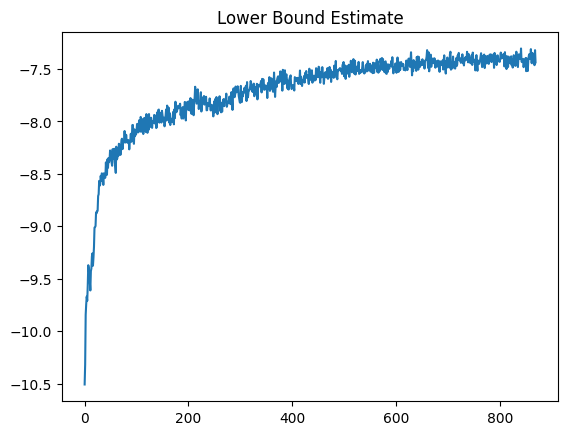

In [32]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

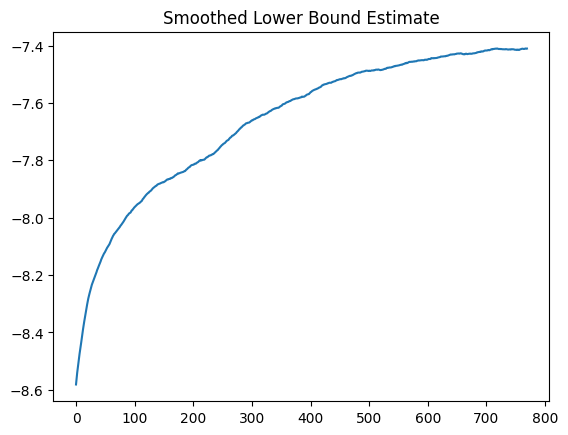

In [33]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [100]:
best_mu = best_lambda[0]
best_vech_l = list(best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)

best_alpha = best_theta_tilde[0]
best_beta = np.exp(best_theta_tilde[1])
best_gamma = best_theta_tilde[2]
best_delta = np.exp(best_theta_tilde[3])
best_theta = np.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.19083119, 10.03349681,  1.15648774,  8.02908466])

Text(0.5, 1.0, 'Posterior density of alpha')

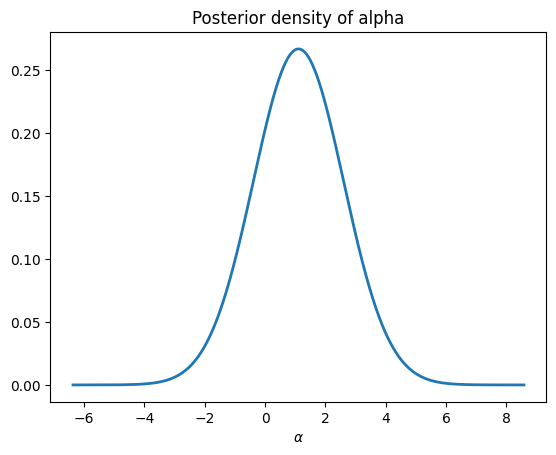

In [35]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-5*np.std(best_alpha)), (np.mean(best_alpha)+5*np.std(best_alpha)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_alpha), np.std(best_alpha))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of beta')

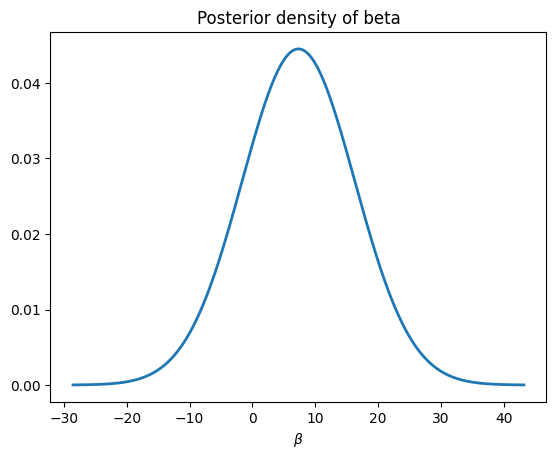

In [36]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_beta), np.std(best_beta))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

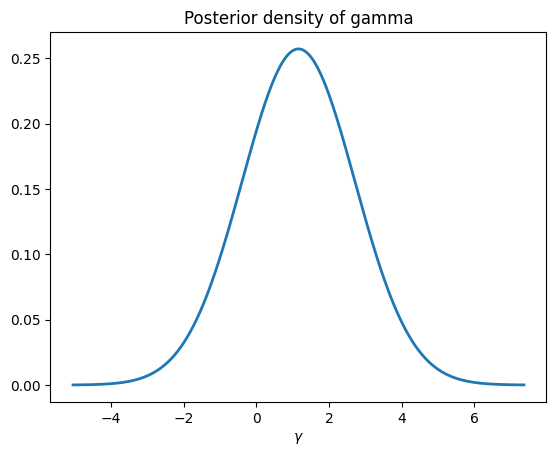

In [37]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_gamma), np.std(best_gamma))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')